# Challenge 2 - Air Quality Prediction in Busy Streets
### World Data League - Stage 1

- Stadhouderskade is one of the busiest and important streets of Amsterdam;
- The Green Mile wants to transform the street to a place where people stay;
- One of the aim, will be to decrease the air pollution on the street.

**Goal:** The goal of this challenge is to help the initiators of the project create a case and buzz for the needed
change in the street and more specifically for the current impact it has on air pollution.

**Outcome:** Create an explainable predictive model for the different pollutants that are produced at Stadhouderskade.

**Main Dataset:** Hourly measurements of air quality


## A. Authors

<ul>
  <li>Diogo Pessoa</li>
  <li>Fábio Lopes</li>
   <li>Francisco Valente</li> 
  <li>Júlio Medeiros</li>
  
</ul>

## B. External Links and Resources

Dataset provided by the WDL 2022 Organisation:

<ul>
  <li><a href="https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv">https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv</a></li>
</ul>

External weather information provided by Open Weather API

## Executive Summary

## Introduction

Nowadays, more and more governments and/or institutions try to combat pollution by implementing policies or suggesting various measures that can directly or indirectly reduce pollution. Pollution comes mostly from anthropogenic origin: industry; land, sea or air traffic; production of energy and use of this energy for residential and/or commercial use; biomass burning; and from agriculture. Furthermore, this pollution has huge impacts on environmental sustainability as well as human health. More precisely, there is scientific evidence of the association between environmental pollution and lung diseases and/or cancers.

In the last decades, given the traffic of vehicles, industries, and tourism in Amsterdam, the city was found high levels of concentration of pollutants in their busiest roads, being Stadhouderskade one of the most significant examples. In order to fight that tendency, over the last few years, some policies have been already implemented to turn the city of Amsterdam into a greener and more sustainable place. Some examples include:

- The banning of polluting scooters (at least since 2018) [1]
- The implementation of low emission zones (at least since 2019) [2] [3]
- The installation of blue-green roofs (at least since 2018) [4]

The city aims to be completely emission-free by 2050, and so there is a great focus on these kind of policies [5]. Actually, Amsterdam is already considered one of the greenest cities in the world [5]. 

Nevertheless, there are still some policies or measures that can be adopted to reduce the level of pollutants. This is where this challenge comes in. Through the development of explainables models for the different pollutants that are observed at Stadhouderskade, we aim to suggest potential measures that can have a positive impact and improve the city’s sustainability

### Particles Sources

There are eight pollutants being evaluated in this project:


- **C6H6 (Benzene)**
- **C7H8 (Cycloheptatriene)**
- **FN (Nitrogen Monofluoride)**
- **NO (Nitric oxide)**
- **NO2 (Nitric dioxide)**
- **PM10 (Particles of a diameter of 10 $\mu m$ or less)**
- **PM25 (Particles of a diameter of 2.5 $\mu m$ or less)**

These particles can have multiple sources, in different scenarios. In fact, people can be exposed to them depending on specific individual life styles, like the industry where they work in, if they are or not smokers, etc. Our first step was to study and analyze the overall environmental sources, i.e., the sources to which humans can be exposed to in a street like Stadhouderskade. The goal is to get the first considerations about what can cause higher levels of those pollutants and what can be done to reduce them, generating the first hypotheses.

In the following table, those environmental sources are presented.



| Pollutants | Sources | 
| --- | --- |
| C6H6 (Benzene) |  crude oil, gasoline fumes, motor vehicle exhaust emission, cigarette and secondhand smoke, emissions from factories and gas stations [6] |
| C7H8 (Cycloheptatriene) | Automobile emissions are the principal source of toluene [7] | 
| C8H10 (Ethylbenzene) |  industrial operations, motor vehicle exhaust emission, gasoline, cigarette smoke, printing ink and varnishes  [8] [9] | 
| FN (Nitrogen Monofluoride) | ("no information on the environmental occurrence of nitrogen trifluoride was found in the available literature" [10] ) | 
| NO (Nitric oxide) | automotive engines, thermal power plants [11] | 
| NO2 (Nitric dioxide) | automobile exhaust, emissions from factories  [12] | 
| PM10 (Particles of a diameter of 10 μg or less) | motor vehicle exhaust emission, emissions from factories, pollen, dust and dirst from construction, tyre abrasion, power generation  [13] [14] [15] | 
| PM25 (Particles of a diameter of 2.5 μg or less) | motor vehicle exhaust emission, emissions from factories, smoke from wood heaters and power plants [16] [17] [18]| 


Based on that, we are able to generate some first hypothesis:

- motor vehicle exhaust emission is a major pollution source, so it is expected that they have higher levels when there is more traffic, like rush hours during the working days.

- industrial and commercial operations is anoter major pollution source, so it is expected a basal/constant high level over the days, being more intense during the week days.

- ...

- ...


## Development

Development section is divided in the following subsections:

<ul>
    <li>Import packages</li>
    <li>Custom functions</li>
    <li>Load datasets</li>
    <li>Exploratory Data Analysis</li>
    <li>Remove noisy data</li>
    <li>Prepare the data to develop the explainable prediction models</li>
    <li>Development of the explainable prediction models</li>
    <li>Evaluating and understanding of the predictions obtained from the explainable prediction models</li>
</ul>


## Requirements


In [1]:
!pip install holidays
!pip install suntime
!pip install statsmodels
!pip install seaborn
!pip install matplotlib==3.4.3
!pip install shap

## Import Packages

In [2]:
import os
import numpy as np
import pandas as pd
import requests
import datetime
import time
import ast
import holidays
from suntime import Sun
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
import matplotlib.pyplot as plt
import matplotlib.dates as md
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from dateutil.relativedelta import relativedelta
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import shap

## Custom functions

In [30]:
# Predict the values for all particles
def predict_all_particles(rf_models,X_tests):
    y_preds = []
    for index,X_test in enumerate(X_tests):
        y_pred = rf_models[index].predict(X_test)
        y_preds.append(y_pred)
        
    return tuple(y_preds)

# Train prediction models for all particles
def train_rf_models(hyperparameters,X,y):
    
    n_trees = hyperparameters[0]
    max_depths = hyperparameters[1]
    all_rf_models = []
    
    for index,n_tree in enumerate(n_trees):
        max_depth = max_depths[index]
        all_rf_models.append(RandomForestRegressor(n_estimators=n_tree, max_depth=max_depth).fit(X[index],y[index]))
    
    return tuple(all_rf_models)

# Split data by particle and remove samples with particle value missing
def split_data_particle(X,y):
    X_c6h6 = X[~np.isnan(y[:,0]),:]
    X_c7h8 = X[~np.isnan(y[:,1]),:]
    X_c8h10 = X[~np.isnan(y[:,2]),:]
    X_fn = X[~np.isnan(y[:,3]),:]
    X_no = X[~np.isnan(y[:,4]),:]
    X_no2 = X[~np.isnan(y[:,5]),:]
    X_pm10 = X[~np.isnan(y[:,6]),:]
    X_pm25 = X[~np.isnan(y[:,7]),:]

    y_c6h6 = y[:,0][~np.isnan(y[:,0])]
    y_c7h8 = y[:,1][~np.isnan(y[:,1])]
    y_c8h10 = y[:,2][~np.isnan(y[:,2])]
    y_fn = y[:,3][~np.isnan(y[:,3])]
    y_no = y[:,4][~np.isnan(y[:,4])]
    y_no2 = y[:,5][~np.isnan(y[:,5])]
    y_pm10 = y[:,6][~np.isnan(y[:,6])]
    y_pm25 = y[:,7][~np.isnan(y[:,7])]
    
    return X_c6h6,X_c7h8,X_c8h10,X_fn,X_no,X_no2,X_pm10,X_pm25,y_c6h6,y_c7h8,y_c8h10,y_fn,y_no,y_no2,y_pm10,y_pm25

# Get the dates when pollutants have no nans
def get_non_nan_dates(X,y):
    
    dates_c6h6 = X.index[np.argwhere(~np.isnan(y[:,0]))]
    dates_c6h6 = pd.to_datetime(dates_c6h6)
    dates_c6h6 = [str(i[0].date()) for i in dates_c6h6]
    dates_c7h8 =  X.index[np.argwhere(~np.isnan(y[:,1]))]
    dates_c7h8 = pd.to_datetime(dates_c7h8)
    dates_c7h8 = [str(i[0].date()) for i in dates_c7h8]
    dates_c8h10 =  X.index[np.argwhere(~np.isnan(y[:,2]))]
    dates_c8h10 = pd.to_datetime(dates_c8h10)
    dates_c8h10 = [str(i[0].date()) for i in dates_c8h10]
    dates_fn =  X.index[np.argwhere(~np.isnan(y[:,3]))]
    dates_fn = pd.to_datetime(dates_fn)
    dates_fn = [str(i[0].date()) for i in dates_fn]
    dates_no =  X.index[np.argwhere(~np.isnan(y[:,4]))]
    dates_no = pd.to_datetime(dates_no)
    dates_no = [str(i[0].date()) for i in dates_no]
    dates_no2 =  X.index[np.argwhere(~np.isnan(y[:,5]))]
    dates_no2 = pd.to_datetime(dates_no2)
    dates_no2 = [str(i[0].date()) for i in dates_no2]
    dates_pm10 =  X.index[np.argwhere(~np.isnan(y[:,6]))]
    dates_pm10 = pd.to_datetime(dates_pm10)
    dates_pm10 = [str(i[0].date()) for i in dates_pm10]
    dates_pm25 =  X.index[np.argwhere(~np.isnan(y[:,7]))]
    dates_pm25 = pd.to_datetime(dates_pm25)
    dates_pm25 = [str(i[0].date()) for i in dates_pm25]
    
    return dates_c6h6,dates_c7h8,dates_c8h10,dates_fn,dates_no,dates_no2,dates_pm10,dates_pm25

# Separate the features from the concentration values (labels)
def divide_features_labels(train_set,test_set,features_indexes,labels_indexes):
    
    train_set_values = train_set.values
    test_set_values = test_set.values

    X_train = train_set_values[:,features_indexes]
    y_train = train_set_values[:,labels_indexes]

    X_test = test_set_values[:,features_indexes]
    y_test = test_set_values[:,labels_indexes]
    
    return X_train,X_test,y_train,y_test

# Convert temperature from Kelvin to Celsius
def kelvin_to_celsius(data):
    data = data - 273.15
    return data

# Identify and remove outliers
def outlier_removal(dataframe,window_samples,number_of_stds,particle_names):
    
    for particle_name in particle_names:
        dataframe_column_values = dataframe[particle_name].values
        number_of_samples = dataframe_column_values.shape[0]
        begin_window_index = 0
        last_window_index = window_samples

        filtered_dataframe_column_values = []
        for index,sample in enumerate(dataframe_column_values):
            if last_window_index!=number_of_samples:
                begin_window_index = index
                last_window_index = begin_window_index+window_samples

            window_values = dataframe_column_values[begin_window_index:last_window_index]
            avg_window = np.nanmean(window_values)
            std_window = np.nanstd(window_values)
            
            if sample > avg_window + number_of_stds * std_window:
                sample = avg_window + number_of_stds * std_window

            if sample < avg_window - number_of_stds * std_window:
                sample = avg_window - number_of_stds * std_window

            filtered_dataframe_column_values.append(sample)
        
        dataframe[particle_name] = filtered_dataframe_column_values
    
    return dataframe  
    
# Convert negative particle concentrations to NaNs
def convert_negative_to_nans(dataframe,particle_names):
    
    nan_samples = []
    all_nan_samples = dataframe[dataframe.isna().all(axis=1)].size
    
    for particle_name in particle_names:
        dataframe[particle_name][dataframe[particle_name]<0] = np.nan
        particle_nan_samples = dataframe[particle_name][dataframe[particle_name].isna()].size
        nan_samples.append(particle_nan_samples)
        
    return dataframe,np.array(nan_samples),np.array(all_nan_samples)

# Extract features from the dates
def get_date_features(dataframe):
    # Get number of samples
    number_samples = dataframe.shape[0]
    
    # Convert date to columns (year, month, day and hour)
    dataframe_dates = pd.to_datetime(dataframe.index.values)
    dataframe['Year'] = dataframe_dates.year
    dataframe['Month'] = dataframe_dates.month
    dataframe['Day'] = dataframe_dates.day
    dataframe['Hour'] = dataframe_dates.hour
    
    # Get Netherlands (NL) holidays
    dataframe_holidays = []
    netherlands_holidays = holidays.Netherlands()
    
    # Get weekday name for each index returned by weekday function provided by pandas library
    dataframe_weekdays = []
    dataframe_weekdays_binary = np.zeros((number_samples,7))
    
    # Get day stages (morning, afternoon, night)
    dataframe_day_stage = []
    dataframe_day_stage_binary = np.zeros((number_samples,3))
    sun = Sun(coordinates[0],coordinates[1])
    
    # Get season (winter, spring, summer, autumn)
    Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
    seasons = [(0, (datetime.date(Y,  1,  1),  datetime.date(Y,  3, 20))),
               (1, (datetime.date(Y,  3, 21),  datetime.date(Y,  6, 20))),
               (2, (datetime.date(Y,  6, 21),  datetime.date(Y,  9, 22))),
               (3, (datetime.date(Y,  9, 23),  datetime.date(Y, 12, 20))),
               (0, (datetime.date(Y, 12, 21),  datetime.date(Y, 12, 31)))]
    
    dataframe_season = []
    dataframe_season_binary = np.zeros((number_samples,4))
    
    # Verify if date is a holiday in NL
    # Get the day of the week
    # Get sunrise and sunset times
    for index,date in enumerate(dataframe_dates):
        
        # Verify if the date is a holiday in NL
        if date in netherlands_holidays:
            dataframe_holidays.append(1)
        else:
            dataframe_holidays.append(0)
        
        # Get the day of the week
        date_weekday = date.weekday()
        dataframe_weekdays.append(date_weekday)
        dataframe_weekdays_binary[index,date_weekday] = 1
        
        # Get sunrise and sunset times (These values come with UTC time zone. No correction needed.)
        sunrise_time = sun.get_sunrise_time(date)
        sunrise_hour = sunrise_time.hour
        sunrise_minute = sunrise_time.minute
        sunset_time = sun.get_sunset_time(date)
        sunset_hour = sunset_time.hour
        sunset_minute = sunset_time.minute
        
        # Get date hours
        date_hour = date.hour
        
        # 11 UTC is 12 CET
        if date_hour<11 and date_hour>sunrise_hour:
            day_stage = 0 # Morning
                
        elif date_hour>=11 and date_hour<=sunset_hour:
            day_stage = 1 # Afternoon
                
        else:
            day_stage = 2 # Night
            
        dataframe_day_stage.append(day_stage)
        dataframe_day_stage_binary[index,day_stage] = 1
            
        date = date.replace(year=Y)
        season =  next(season for season, (start, end) in seasons if start <= date <= end)
        
        dataframe_season.append(season)
        dataframe_season_binary[index,season] = 1
        

    # Store both information in the main dataset
    dataframe['Holiday'] = dataframe_holidays
    dataframe['Weekday'] = dataframe_weekdays
    dataframe['Monday'] = dataframe_weekdays_binary[:,0]
    dataframe['Tuesday'] = dataframe_weekdays_binary[:,1]
    dataframe['Wednesday'] = dataframe_weekdays_binary[:,2]
    dataframe['Thursday'] = dataframe_weekdays_binary[:,3]
    dataframe['Friday'] = dataframe_weekdays_binary[:,4]
    dataframe['Saturday'] = dataframe_weekdays_binary[:,5]
    dataframe['Sunday'] = dataframe_weekdays_binary[:,6]
    dataframe['Day Stage'] = dataframe_day_stage
    dataframe['Morning'] = dataframe_day_stage_binary[:,0]
    dataframe['Afternoon'] = dataframe_day_stage_binary[:,1]
    dataframe['Night'] = dataframe_day_stage_binary[:,2]
    dataframe['Season'] = dataframe_season
    dataframe['Winter'] = dataframe_season_binary[:,0]
    dataframe['Spring'] = dataframe_season_binary[:,1]
    dataframe['Summer'] = dataframe_season_binary[:,2]
    dataframe['Autumn'] = dataframe_season_binary[:,3]
    
    return dataframe                                                                       

# Get percentage of samples in each column and remove the ones that have a number of nans higher than threshold
def remove_nans_columns(dataframe,threshold_nans,labels_columns,maintained_columns):
    number_samples = dataframe.shape[0]
    number_columns = dataframe.shape[1]
    nans_columns = []
    
    for column_index in range(number_columns):
        nans_column = dataframe.iloc[:,column_index].isna().sum()
        nans_columns.append(nans_column)
    
    nans_columns = np.array(nans_columns)
    nans_columns = nans_columns/number_samples
    
    if len(maintained_columns)==0:
        for column_index,nans_column in enumerate(nans_columns):
            if column_index in labels_columns or nans_column <= threshold_nans:
                maintained_columns.append(column_index)
    
    maintained_columns = np.array(maintained_columns)
    dataframe = dataframe.iloc[:,maintained_columns]
    
    return dataframe,nans_columns,maintained_columns

# Get data from url
def get_info_api(url):
    url_res = requests.get(url)
    url_data = url_res.json()
    return url_data

# Get weather information from OpenWeather API
def get_weather_dataset(coordinates, api_key, datetime_begin):
    
    # Convert from datetime to unix time
    unix_time_begin = int(time.mktime(datetime_begin.timetuple()))
    
    # 7 days of data are 169 timesteps
    cnt = 169
    
    # Extract latitude and longitude of the city
    latitude,longitude = coordinates
    
    # Prepare URL to request
    weather_url = f"http://history.openweathermap.org/data/2.5/history/city?lat={latitude}&lon={longitude}&type=hour&start={unix_time_begin}&cnt={cnt}&appid={api_key}"
    
    # Request
    weather_json = get_info_api(weather_url)
    
    # From JSON to Pandas Dataframe
    weather_dataframe = pd.DataFrame(weather_json['list'])
    
    # Get current date
    datetime_now = datetime.datetime.now().date()

    while datetime_begin < datetime_now:
        
        # OpenWeather API only allow us to download 7 days of data each time we make a request
        datetime_begin = datetime_begin + datetime.timedelta(days=7)
        unix_time_begin = int(time.mktime(datetime_begin.timetuple()))
        
        # Prepare URL to request
        weather_url = f"http://history.openweathermap.org/data/2.5/history/city?lat={latitude}&lon={longitude}&type=hour&start={unix_time_begin}&cnt={cnt}&appid={api_key}"
        
        # Request
        weather_json = get_info_api(weather_url)
        
        # Concatenate the new data with the previous
        weather_dataframe = pd.concat([weather_dataframe,pd.DataFrame(weather_json['list'])],ignore_index=True)
    
    return weather_dataframe

# Plots
def Boxplots_particles(column, labels):
    pollution_weather_dataset_daystage = pollution_weather_dataset.dropna().groupby(column)

    fig, axs = plt.subplots(4,2,figsize=(17,15),sharex=False, constrained_layout=True)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.1)
    fig.suptitle(column, fontsize=22)
    fig.tight_layout(pad=2)
    
    axs = axs.ravel()
    particles_names = ['C6H6','C7H8','C8H10','FN','NO','NO2','PM10','PM25']

    for i,particle_name in enumerate(particles_names):

        axs[i].boxplot(pollution_weather_dataset_daystage[particle_name].apply(np.array).values,labels=labels)
        axs[i].set_title(particle_name)
        axs[i].set_ylabel('ug/m3')
        

def Plots_autocorrelation_particles(dataframe):
    
    fig, axs = plt.subplots(4,2,figsize=(20,15),sharex=False, constrained_layout=True)
    fig.subplots_adjust(hspace = 0.5, wspace = 1.0)
    fig.suptitle('Auto-Correlation', fontsize=22)
    fig.tight_layout(pad=4)

    axs = axs.ravel()
    particles_names = ['C6H6','C7H8','C8H10','FN','NO','NO2','PM10','PM25']

    for i,particle_name in enumerate(particles_names):

        plot_acf(dataframe[particle_name].dropna().values,lags=100,ax=axs[i])
        axs[i].set_title(particle_name)

        dftest = adfuller(dataframe[particle_name].dropna().values)

        if dftest[0]<dftest[4]['5%'] and dftest[1]<0.05:
            axs[i].text(90, .75, "Stationary",fontsize=12)
        else:
            axs[i].text(90, .75, "Non-Stationary",fontsize=12)
            
        pos = [0,24,48,72,96]
        axs[i].set_xticks(pos)
        axs[i].set_xlabel('Delay (hours)')
        axs[i].set_ylabel('Correlation')
        axs[i].set_ylim([-0.1, 1.1])          

def Plots_particleConcentration_perHour(dataframe, 
                                        title = None,
                                        options = ["Weekday", "Month", "Season"],
                                        Plot_lines = True,
                                        Plot_heatmap = True,
                                        metric = 'mean'):
    
    weekdays = np.sort(dataframe["Weekday"].unique())
    months = np.sort(dataframe["Month"].unique())
    seasons = np.sort(dataframe["Season"].unique())
    
    particles = ['C6H6', 'C7H8', 'C8H10', 'FN', 'NO', 'NO2', 'PM10', 'PM25']
    
    weekdays_dict = { 0: "Mon", 1: "Tue", 2: "Wed", 3: "Thurs", 4: "Frid", 5: "Sat", 6: "Sund"}
    months_dict = { 1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul",
                   8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec" }
    seasons_dict = { 0: "Winter", 1: "Spring", 2: "Summer", 3: "Autumn" }
    
    data = []
    
    for opt in options:
        if Plot_lines == True:
            fig, axs = plt.subplots(nrows=4, ncols=2, clear=True, constrained_layout=True, figsize=(20, 15))
            axs = axs.ravel()
        
        if Plot_lines == True:
            if(title != None):
                fig.suptitle(title + " " + opt, fontsize=22)
       
        locals()['data_' + opt + '_all_particles'] = []            
        locals()['heatmaps_' + opt + '_all_particle'] = []     
        
        for idx, p in enumerate(particles):

             locals()['data_' + opt + '_all_particle'] = []     
             if(opt == 'Weekday'):
                 current_opt = weekdays
                 current_dict = weekdays_dict
                 number_items = weekdays.shape[0] 
             elif(opt == 'Month'):
                 current_opt = months
                 current_dict = months_dict
                 number_items = months.shape[0]
             elif(opt == 'Season'):
                 current_opt = seasons
                 current_dict = seasons_dict
                 number_items = seasons.shape[0]

             matrix_heatmap = np.zeros((number_items, 24))
            
             locals()['data_' + opt + '_particle'] = []
             for idx_item, i in enumerate(current_opt):  
                 pollution_perday = dataframe.loc[(dataframe[opt] == i)].dropna()
                 if (metric == 'mean'):
                     data_item = pollution_perday.groupby(['Hour']).mean()[p]
                 elif (metric == 'median'):
                     data_item = pollution_perday.groupby(['Hour']).median()[p]
                 locals()['data_' + opt + '_particle'].append(data_item)
                 
                 if Plot_lines == True:
                     axs[idx].set_title(p)   
                     axs[idx].plot(data_item)
                     axs[idx].legend([current_dict[item] for item in current_opt], loc = 'upper right')
                     axs[idx].set_xlabel("Time (Hours)")
                     axs[idx].set_ylabel('ug/m3')
                    
                 matrix_heatmap[idx_item,:] = data_item
             
             locals()['data_' + opt + '_all_particles'].append(locals()['data_' + opt + '_particle'])
             locals()['heatmaps_' + opt + '_all_particle'].append(matrix_heatmap)    
        
        locals()['data_' + opt + '_all_particles'].append(current_opt)
        data.append(locals()['data_' + opt + '_all_particles'])
            
    # Plots heatmaps
    if Plot_heatmap == True:
        for opt in options:
            if(opt == 'Weekday'):
                current_opt = weekdays
                current_dict = weekdays_dict
                number_items = weekdays.shape[0] 
            elif(opt == 'Month'):
                current_opt = months
                current_dict = months_dict
                number_items = months.shape[0]
            elif(opt == 'Season'):
                current_opt = seasons
                current_dict = seasons_dict
                number_items = seasons.shape[0]

            fig, axs = plt.subplots(nrows=4, ncols=2, clear=True, constrained_layout=True, figsize=(15, 15))
            axs = axs.ravel()   

            if Plot_heatmap == True:
                if(title != None):
                    fig.suptitle(title + " " + opt, fontsize=22)

            for idx, p in enumerate(particles):

                matrix_heatmap_data = locals()['heatmaps_' + opt + '_all_particle'][idx]

                axs[idx].set_title(p)   
                #sns.heatmap(matrix_heatmap_weekdays, ax=axs[idx])
                sublplot_i = axs[idx].imshow(matrix_heatmap_data, cmap = 'bwr') # interpolation = 'gaussian' 'spline16'
                axs[idx].set_xlabel("Time (Hours)")
                axs[idx].set_yticks(range(number_items))
                axs[idx].set_yticklabels([current_dict[item] for item in current_opt])
                c = plt.colorbar(sublplot_i, ax=axs[idx])
                c.ax.set_ylabel('ug/m3', labelpad=10)
        
    return data

def plot_feature_importances(models, X_tests, particles_names):
    
    feature_names = ['temp', 'feels_like', 'pressure', 'humidity', 'temp_min', 'temp_max',
       'wind_speed', 'wind_deg', 'clouds', 'Year', 'Month', 'Day', 'Hour',
       'Holiday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'Morning', 'Afternoon', 'Night', 'Winter',
       'Spring', 'Summer', 'Autumn', 'Clear', 'Clouds', 'Drizzle', 'Fog',
       'Mist', 'Rain', 'Snow', 'broken clouds', 'clear sky', 'drizzle',
       'few clouds', 'fog', 'heavy intensity rain', 'light intensity drizzle',
       'light intensity drizzle rain', 'light intensity shower rain',
       'light rain', 'light snow', 'mist', 'moderate rain', 'overcast clouds',
       'scattered clouds', 'sky is clear', 'snow']

    for i,particle_name in enumerate(particles_names):
        model = models[particle_name]
        X_test = X_tests[i]
        dataframe = pd.DataFrame(X_test,columns=feature_names)
        explainer = shap.Explainer(model.predict, dataframe)
        shap_values = explainer(dataframe)
        print(f'SHAP Values: {particle_name} - 1 Week')
        shap.plots.beeswarm(shap_values)
        
def plot_trueVSpredicted(models, particles_names):

    fig, axs = plt.subplots(4,2,figsize=(20,15),sharex=False)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.1)
    axs = axs.ravel()
    fig.suptitle(models['forecasting'], fontsize=20)
    
    for i,particle_name in enumerate(particles_names):
        
        model = models[particle_name]
        axs[i].plot(model[0], label = 'True')
        axs[i].plot(model[1], label = 'Predicted')
        axs[i].set_title(particle_name)
        pos = np.arange(0, len(model[0]), np.round(len(model[0])/10))
        pos = pos.astype(int)
        dates = np.array(model[2])
        axs[i].set_xticks(pos)
        axs[i].set_xticklabels(dates[pos])
        axs[i].tick_params(rotation=20)
        axs[i].legend()

## Load Datasets

In this subsection, we load the datasets:

<ul>
    <li><i>pollution_dataset</i> contains the hourly measurements of air quality of Stadhouderskade, Amsterdam, Netherlands dataset organised by datetime</li>
    <li><i>weather_dataset</i> contains the weather information of the last year of Stadhouderskade, Amsterdam, Netherlands dataset organised by datetime</li>
    <li><i>pollution_weather_dataset</i> is a dataset obtained by merging the <i>weather_dataset</i> and <i>pollution_dataset</i></li>
</ul>

In [4]:
# Coordinates of Stadhouderskade, Amsterdam, Netherlands
coordinates = (52.359747,4.887624)

# Get filepath of the Hourly measurements of air quality dataset
pollution_dataset_filename = 'https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv'

# Load Hourly measurements of air quality dataset
raw_pollution_dataset = pd.read_csv(pollution_dataset_filename)

# Convert time string to datetime and remove time zone
raw_pollution_dataset['timestamp_measured'] = pd.to_datetime(raw_pollution_dataset['timestamp_measured']).dt.tz_localize(None)
last_pollution_datetime = np.max(raw_pollution_dataset['timestamp_measured'])

# Download Open Weather Dataset

# API key
api_key = "9912d5eda833d9b373814b1940ca2ead"

# Starting datetime
datetime_end = datetime.datetime.now().date()
datetime_begin = datetime_end - relativedelta(days=364)

# Get Weather dataset
weather_dataset = get_weather_dataset(coordinates, api_key, datetime_begin)

# Convert unix time to datetime
weather_dataset['dt'] = pd.to_datetime(weather_dataset['dt'],unit='s')

# Remove datetimes that are not in the pollution dataset
weather_dataset_last_pollution_sample_mask = weather_dataset['dt'] <= last_pollution_datetime
weather_dataset = weather_dataset[weather_dataset_last_pollution_sample_mask]

# Obtain weather values
weather_values_dictionary = {'temp':[],'feels_like':[],'pressure':[],
                             'humidity':[],'temp_min':[],'temp_max':[],
                             'wind_speed':[],'wind_deg':[],'clouds':[],
                             'weather':[],'weather_description':[],
                             'rain_last_1h':[],'snow_last_1h':[],
                             'rain_last_3h':[],'snow_last_3h':[]}

for index,sample in weather_dataset.iterrows():

    # Get main values
    main_values = sample['main']
    weather_values_dictionary['temp'].append(main_values['temp'])
    weather_values_dictionary['feels_like'].append(main_values['feels_like'])
    weather_values_dictionary['pressure'].append(main_values['pressure'])
    weather_values_dictionary['humidity'].append(main_values['humidity'])
    weather_values_dictionary['temp_min'].append(main_values['temp_min'])
    weather_values_dictionary['temp_max'].append(main_values['temp_max'])

    # Get wind values
    wind_values = sample['wind']
    weather_values_dictionary['wind_speed'].append(wind_values['speed'])
    weather_values_dictionary['wind_deg'].append(wind_values['deg'])

    # Get cloudiness value
    clouds_values = sample['clouds']
    weather_values_dictionary['clouds'].append(clouds_values['all'])

    # Get weather description
    weather_values = sample['weather']
    weather_values_dictionary['weather'].append(weather_values[0]['main'])
    weather_values_dictionary['weather_description'].append(weather_values[0]['description'])

    # Get rain values
    rain_values = sample['rain']
    if rain_values==rain_values:
        if '1h' in rain_values.keys():
            weather_values_dictionary['rain_last_1h'].append(rain_values['1h'])
        else:
            weather_values_dictionary['rain_last_1h'].append(np.nan)

        if '3h' in rain_values.keys():
            weather_values_dictionary['rain_last_3h'].append(rain_values['3h'])
        else:
            weather_values_dictionary['rain_last_3h'].append(np.nan)
    else:
        weather_values_dictionary['rain_last_1h'].append(np.nan)
        weather_values_dictionary['rain_last_3h'].append(np.nan)

    # Get snow values
    snow_values = sample['snow']
    if snow_values==snow_values:
        if '1h' in snow_values.keys():
            weather_values_dictionary['snow_last_1h'].append(snow_values['1h'])
        else:
            weather_values_dictionary['snow_last_1h'].append(np.nan)

        if '3h' in snow_values.keys():
            weather_values_dictionary['snow_last_3h'].append(snow_values['3h'])
        else:
            weather_values_dictionary['snow_last_3h'].append(np.nan)
    else:
        weather_values_dictionary['snow_last_1h'].append(np.nan)
        weather_values_dictionary['snow_last_3h'].append(np.nan)

# Save weather dataset datetimes
weather_dataset_datetimes = weather_dataset['dt']

# Rebuild weather dataset
weather_dataset = pd.DataFrame(weather_values_dictionary)
weather_dataset['dt'] = weather_dataset_datetimes
weather_dataset = weather_dataset.set_index('dt')

# Merge Datasets

# Get first and last datetimes
first_datetime_weather_dataset = np.min(weather_dataset.index)
last_datetime_weather_dataset = np.max(weather_dataset.index)

# Split pollution dataset (one subset without weather data and other with)
pollution_dataset_before_weather_mask = raw_pollution_dataset['timestamp_measured'] < first_datetime_weather_dataset
pollution_dataset_merge_weather_mask = pollution_dataset_before_weather_mask == False
pollution_dataset_before_weather = raw_pollution_dataset[pollution_dataset_before_weather_mask]
pollution_dataset_merge_weather = raw_pollution_dataset[pollution_dataset_merge_weather_mask]

# Merge values by datetime
pollution_dataset_before_weather = pollution_dataset_before_weather.pivot_table('value', ['timestamp_measured'], 'component_id')
pollution_dataset_merge_weather = pollution_dataset_merge_weather.pivot_table('value', ['timestamp_measured'], 'component_id')

# Merge both datasets
pollution_weather_dataset = weather_dataset.join(pollution_dataset_merge_weather)

# Organise particle values by date
pollution_dataset = raw_pollution_dataset.pivot_table('value', ['timestamp_measured'], 'component_id')

print('All datasets loaded!')

All datasets loaded!


## Exploratory Data Analysis

### Pollution Dataset

We started our analysis with the <i>pollution_dataset</i>. First, we obtained features from the datetimes of the <i>pollution_dataset</i>.

In [5]:
# Get date features
pollution_dataset = get_date_features(pollution_dataset)

print('First 5 samples of the pollution dataset')
display(pollution_dataset.head())

print('Last 5 samples of the pollution-weather dataset')
display(pollution_weather_dataset.tail())

First 5 samples of the pollution dataset


component_id,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25,Year,Month,...,Sunday,Day Stage,Morning,Afternoon,Night,Season,Winter,Spring,Summer,Autumn
timestamp_measured,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,27.0,43.0,NaN,NaN,2014,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2014-01-01 01:00:00,1.21,1.41,NaN,2.38,30.0,42.0,90.3,74.7,2014,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2014-01-01 02:00:00,0.97,1.65,NaN,2.55,28.0,50.0,97.3,84.0,2014,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2014-01-01 03:00:00,1.11,1.98,NaN,2.50,24.0,48.0,41.6,34.7,2014,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2014-01-01 04:00:00,1.04,2.31,NaN,2.18,19.0,45.0,28.1,20.6,2014,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0


Last 5 samples of the pollution-weather dataset


,temp,feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds,weather,...,rain_last_3h,snow_last_3h,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25
2022-02-16 18:00:00,284.86,284.41,986,89,283.07,285.99,4.02,211,75,Clouds,...,NaN,NaN,0.39,1.10,0.71,0.48,7.1,17.7,11.5,10.5
2022-02-16 19:00:00,284.97,284.53,985,89,283.07,285.97,3.58,204,75,Clouds,...,NaN,NaN,0.33,0.98,0.62,0.37,6.5,16.8,10.7,6.5
2022-02-16 20:00:00,284.52,284.11,984,92,283.07,285.90,4.02,221,75,Clouds,...,NaN,NaN,0.26,0.56,0.36,0.29,4.2,14.8,7.6,7.5
2022-02-16 21:00:00,284.34,283.89,984,91,283.07,285.87,5.36,217,75,Clouds,...,NaN,NaN,0.18,0.35,0.23,0.20,3.0,11.2,5.8,7.9
2022-02-16 22:00:00,284.14,283.64,985,90,283.07,285.90,5.36,217,40,Clouds,...,NaN,NaN,0.21,0.48,0.30,0.22,4.9,10.0,7.7,7.6


Afterwards, we analysed the number of missing values in the <i>pollution_dataset</i>. It is worth noting that we considered the negative concentration values as missing values.

In [6]:
# Replace negative values by NaN
particle_names = ['C6H6','C7H8','C8H10','FN','NO','NO2','PM10','PM25']
pollution_dataset,pollution_nan_samples,pollution_all_nan_samples = convert_negative_to_nans(pollution_dataset,particle_names)

number_samples_pollution_dataset = pollution_dataset.shape[0]
number_columns_pollution_dataset = pollution_dataset.shape[1]
percentage_pollution_nan_samples = np.round(100 * pollution_nan_samples/number_samples_pollution_dataset,2)
percentage_pollution_all_nan_samples = np.round(100 * pollution_all_nan_samples/number_samples_pollution_dataset,2)

print(f'Pollution dataset contains {number_samples_pollution_dataset} samples and {number_columns_pollution_dataset} columns.')
for index,particle_name in enumerate(particle_names):
    print(f'Pollution dataset contains {percentage_pollution_nan_samples[index]}% samples with missing {particle_name} concentration value.')
print(f'Pollution dataset contains {percentage_pollution_all_nan_samples}% samples with all missing concentration values.\n')

Pollution dataset contains 70843 samples and 30 columns.
Pollution dataset contains 6.61% samples with missing C6H6 concentration value.
Pollution dataset contains 6.46% samples with missing C7H8 concentration value.
Pollution dataset contains 19.62% samples with missing C8H10 concentration value.
Pollution dataset contains 1.3% samples with missing FN concentration value.
Pollution dataset contains 2.77% samples with missing NO concentration value.
Pollution dataset contains 2.47% samples with missing NO2 concentration value.
Pollution dataset contains 2.26% samples with missing PM10 concentration value.
Pollution dataset contains 3.17% samples with missing PM25 concentration value.
Pollution dataset contains 0.0% samples with all missing concentration values.



We verified that pollution dataset contains some missing concentration values. Almost 20% of the C8H10 particle contains are missing. This dataset contains data from 2014-01-01 to 2022-02-16. Therefore, we inspected if these samples were obtained in a specific year or if these ones are spread over the years.

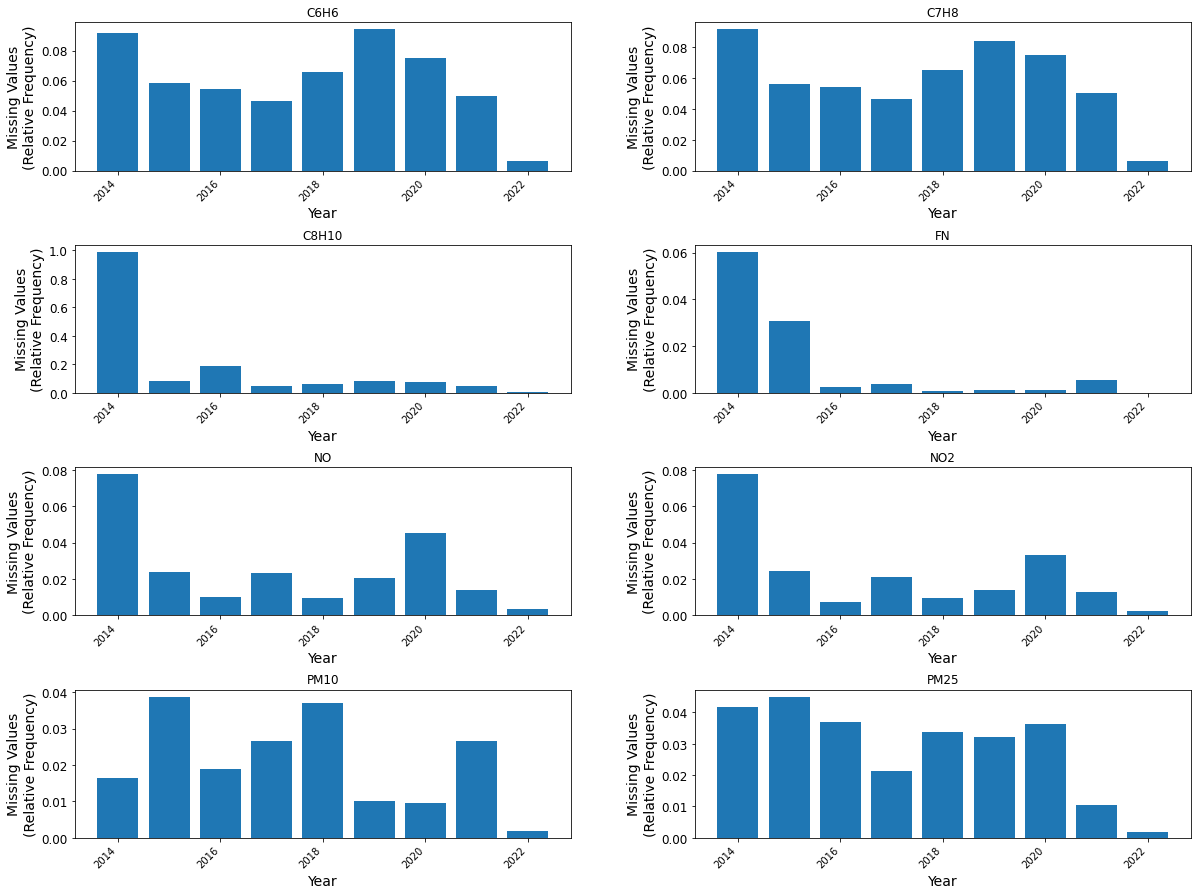

In [7]:
# Split the dataset by year
pollution_dataset_2014 = pollution_dataset.loc['2014-01-01':'2014-12-31']
pollution_dataset_2015 = pollution_dataset.loc['2015-01-01':'2015-12-31']
pollution_dataset_2016 = pollution_dataset.loc['2016-01-01':'2016-12-31']
pollution_dataset_2017 = pollution_dataset.loc['2017-01-01':'2017-12-31']
pollution_dataset_2018 = pollution_dataset.loc['2018-01-01':'2018-12-31']
pollution_dataset_2019 = pollution_dataset.loc['2019-01-01':'2019-12-31']
pollution_dataset_2020 = pollution_dataset.loc['2020-01-01':'2020-12-31']
pollution_dataset_2021 = pollution_dataset.loc['2021-01-01':'2021-12-31']
pollution_dataset_2022 = pollution_dataset.loc['2022-01-01':'2022-12-31']

# Count number of missing values for each particle
pollution_dataset_nan_values_by_year = []
pollution_dataset_nan_values_by_year.append(pollution_dataset_2014.isna().sum()/pollution_dataset_2014.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2015.isna().sum()/pollution_dataset_2015.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2016.isna().sum()/pollution_dataset_2016.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2017.isna().sum()/pollution_dataset_2017.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2018.isna().sum()/pollution_dataset_2018.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2019.isna().sum()/pollution_dataset_2019.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2020.isna().sum()/pollution_dataset_2020.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2021.isna().sum()/pollution_dataset_2021.shape[0])
pollution_dataset_nan_values_by_year.append(pollution_dataset_2022.isna().sum()/pollution_dataset_2022.shape[0])

%matplotlib inline
fig, axs = plt.subplots(4,2,figsize=(20,15),sharex=False)
fig.subplots_adjust(hspace = 0.5, wspace = 0.25)

axs = axs.ravel()

for particle_index,particle_name in enumerate(particle_names):
    particle_missing_values = []
    for year_index,year_values in enumerate(pollution_dataset_nan_values_by_year):
        particle_missing_values.append(year_values[particle_name])
    axs[particle_index].bar([2014,2015,2016,2017,2018,2019,2020,2021,2022],particle_missing_values)
    axs[particle_index].set_title(particle_name)
    axs[particle_index].set_xlabel('Year')
    axs[particle_index].set_ylabel('Missing Values\n(Relative Frequency)')
    
    for label in axs[particle_index].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_fontsize(10)

Bar plots showed that for the year 2014 there is almost no C8H10 values. Therefore, we removed the data of this year from the <i>pollution dataset</i>. For the other years, the number of samples with missing values is below 20% for all particles. Below we present the first 5 samples of the <i>pollution dataset</i> without the values for the year 2014.

In [8]:
pollution_dataset = pollution_dataset.loc['2015-01-01':]
print('First 5 samples of the pollution dataset without the 2014 values')
display(pollution_dataset.head())

First 5 samples of the pollution dataset without the 2014 values


component_id,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25,Year,Month,...,Sunday,Day Stage,Morning,Afternoon,Night,Season,Winter,Spring,Summer,Autumn
timestamp_measured,,,,,,,,,,,,,,,,,,,,,
2015-01-01 01:00:00,1.56,4.52,1.13,7.03,35.6,56.1,222.1,190.6,2015,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2015-01-01 02:00:00,2.08,5.31,1.47,8.60,42.7,59.2,238.9,203.9,2015,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2015-01-01 03:00:00,1.79,4.67,1.23,7.88,30.7,54.2,171.0,148.5,2015,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2015-01-01 04:00:00,1.40,4.53,1.32,6.39,41.4,55.5,66.4,58.6,2015,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0
2015-01-01 05:00:00,1.16,3.79,1.00,4.64,26.6,51.4,49.2,40.3,2015,1,...,0.0,2,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0


Now, we present all the concentrations values for the eight particles which are available in the dataset.

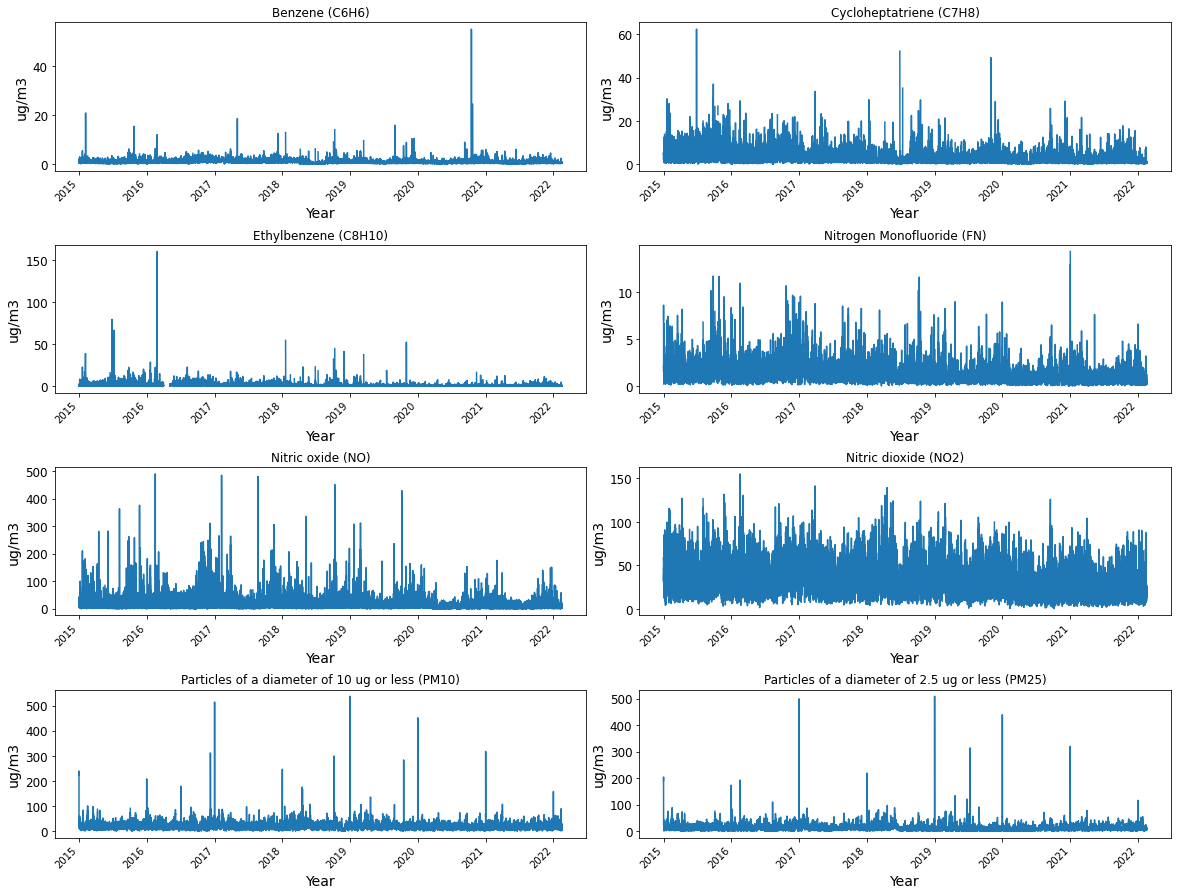

In [9]:
particles_concentration_descriptions = {'C6H6':'Benzene (C6H6)','C7H8':'Cycloheptatriene (C7H8)',
                                        'C8H10':'Ethylbenzene (C8H10)','FN':'Nitrogen Monofluoride (FN)',
                                        'NO':'Nitric oxide (NO)','NO2':'Nitric dioxide (NO2)',
                                        'PM10':'Particles of a diameter of 10 ug or less (PM10)',
                                        'PM25':'Particles of a diameter of 2.5 ug or less (PM25)'}

%matplotlib inline
fig, axs = plt.subplots(4,2,figsize=(20,15),sharex=False)
fig.subplots_adjust(hspace = 0.5, wspace = 0.1)

axs = axs.ravel()

for i in range(8):

    axs[i].plot(pollution_dataset[list(particles_concentration_descriptions.keys())[i]])
    axs[i].set_title(list(particles_concentration_descriptions.values())[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('ug/m3')
    
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_fontsize(10)

Looking into the plots, we verify that there are some outliers in the data. In order to remove the effect of these ones, we replaced them by the average and 2 standard deviations. These statistics are dynamically calculated over the data using a window of 24 hours (24 samples).

In [10]:
window_samples = 24 # 24 hours
number_of_stds = 2

print('Identifying outliers...')
pollution_dataset = outlier_removal(pollution_dataset,window_samples,number_of_stds,particle_names)

Identifying outliers...


Now, we present the same plots but after the attenuation of the outliers.

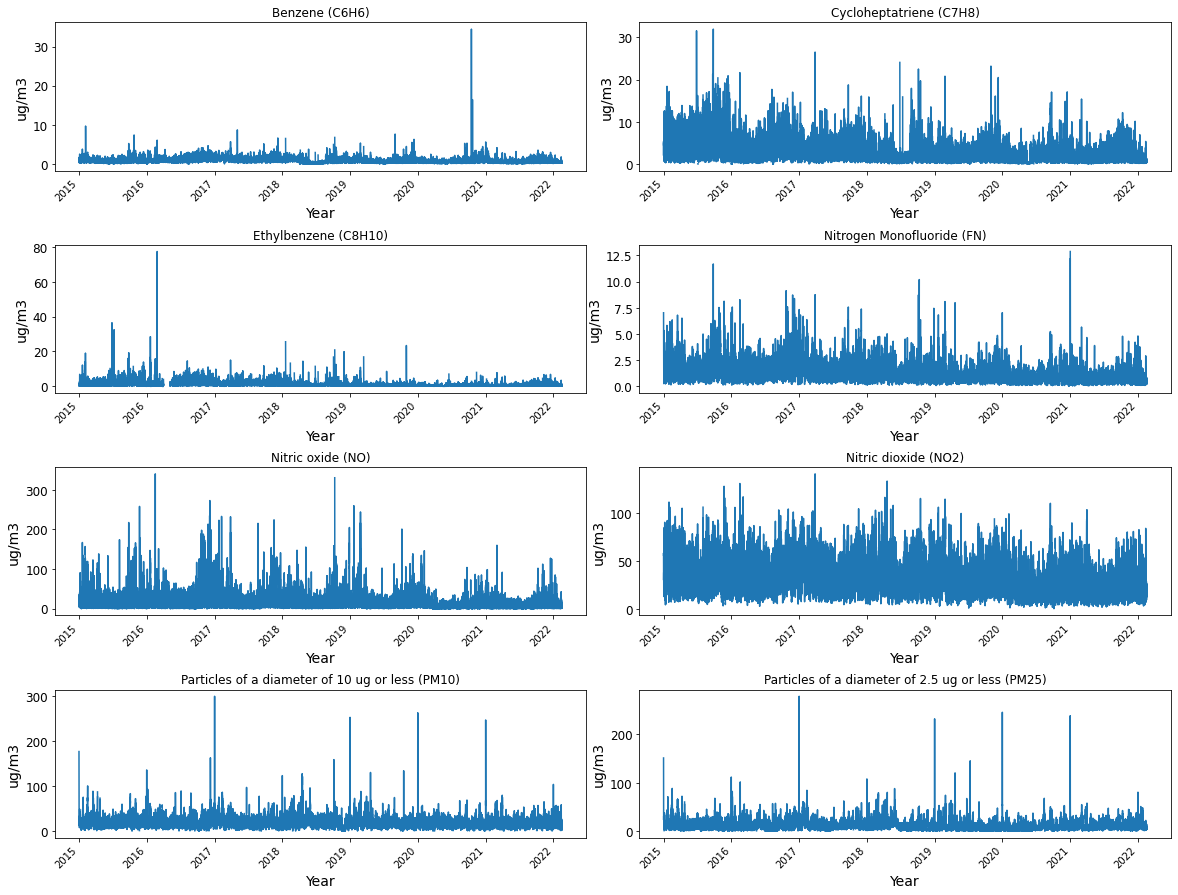

In [11]:
# Data after outlier detection and replacement
particles_concentration_descriptions = {'C6H6':'Benzene (C6H6)','C7H8':'Cycloheptatriene (C7H8)',
                                        'C8H10':'Ethylbenzene (C8H10)','FN':'Nitrogen Monofluoride (FN)',
                                        'NO':'Nitric oxide (NO)','NO2':'Nitric dioxide (NO2)',
                                        'PM10':'Particles of a diameter of 10 ug or less (PM10)',
                                        'PM25':'Particles of a diameter of 2.5 ug or less (PM25)'}

%matplotlib inline
fig, axs = plt.subplots(4,2,figsize=(20,15),sharex=False)
fig.subplots_adjust(hspace = 0.5, wspace = 0.1)

axs = axs.ravel()

for i in range(8):

    axs[i].plot(pollution_dataset[list(particles_concentration_descriptions.keys())[i]])
    axs[i].set_title(list(particles_concentration_descriptions.values())[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('ug/m3')
    
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_fontsize(10)

On the last two years the world has been affected by the COVID-19 pandemy. This pandemy lead to the establishment of two lockdown periods in Netherlands. According to <a href="https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_Netherlands/">[19]</a>, the first period lasted from 12th March 2020 to 1st June 2020, whereas the second one lasted from 15th December 2020 to 15th March 2021. Both periods strongly restricted the population daily habits. Therefore, it is expected to verify a clear difference in the concentration values.

<i>Pollution dataset</i> contains data from these two periods. Therefore, we decided to get two subsets from the pollution dataset in order to compared them with the other years:
<ul>
    <li>During first COVID lockdown</li>
    <li>During second COVID lockdown</li>
</ul>

In [12]:
# Separate dataset by covid status
quarantine_dates = [['2020-03-12','2020-06-01'],
                    ['2020-12-15','2021-03-15']]
pollution_dataset_first_covid_lockdown = pollution_dataset.loc[quarantine_dates[0][0]:quarantine_dates[0][1]]
pollution_dataset_second_covid_lockdown = pollution_dataset.loc[quarantine_dates[1][0]:quarantine_dates[1][1]]


In order to verify what happened during COVID lockdowns, we compared the pollution concentrations from these two periods with those from the same date but in years with no lockdowns.

### First COVID Lockdown

In [13]:
average_particles_2015 = pollution_dataset.loc['2015-03-12':'2015-06-01'].mean(skipna=True)
average_particles_2016 = pollution_dataset.loc['2016-03-12':'2016-06-01'].mean(skipna=True)
average_particles_2017 = pollution_dataset.loc['2017-03-12':'2017-06-01'].mean(skipna=True)
average_particles_2018 = pollution_dataset.loc['2018-03-12':'2018-06-01'].mean(skipna=True)
average_particles_2019 = pollution_dataset.loc['2019-03-12':'2019-06-01'].mean(skipna=True)
average_particles_first_lockdown = pollution_dataset_first_covid_lockdown.mean(skipna=True)
average_particles_2021 = pollution_dataset.loc['2021-03-12':'2021-06-01'].mean(skipna=True)

all_years_avg = pd.concat([average_particles_2015,average_particles_2016,average_particles_2017,
                           average_particles_2018,average_particles_2019,average_particles_first_lockdown,
                           average_particles_2021],axis=1)

all_years_relative = all_years_avg.div(average_particles_first_lockdown,axis=0)
all_years_relative.columns = ['2015','2016','2017','2018','2019','First Lockdown (2020)','2021']

display(all_years_relative.loc['C6H6':'PM25'])

,2015,2016,2017,2018,2019,First Lockdown (2020),2021
component_id,,,,,,,
C6H6,1.792685,2.361271,2.830817,1.736728,1.598825,1.0,1.164758
C7H8,4.203179,2.206307,3.252267,2.265676,1.642629,1.0,1.340454
C8H10,5.576820,5.287850,7.019249,4.178039,2.618466,1.0,1.752076
FN,2.068749,1.762207,1.843853,1.881011,1.437999,1.0,0.912860
NO,2.605120,2.461608,2.845760,2.444484,2.088261,1.0,1.248527
NO2,1.903530,1.716771,1.855728,1.954702,1.512263,1.0,1.105294
PM10,1.136397,1.104394,1.019240,1.395213,1.185239,1.0,0.921077
PM25,1.852936,1.675141,1.368405,2.349050,1.572982,1.0,1.191940


### Second COVID Lockdown

In [14]:
average_particles_2015 = pollution_dataset.loc['2015-12-15':'2016-03-15'].mean(skipna=True)
average_particles_2016 = pollution_dataset.loc['2016-12-15':'2017-03-15'].mean(skipna=True)
average_particles_2017 = pollution_dataset.loc['2017-12-15':'2018-03-15'].mean(skipna=True)
average_particles_2018 = pollution_dataset.loc['2018-12-15':'2019-03-15'].mean(skipna=True)
average_particles_2019 = pollution_dataset.loc['2019-12-15':'2020-03-15'].mean(skipna=True)
average_particles_second_lockdown = pollution_dataset_second_covid_lockdown.mean(skipna=True)
average_particles_2021 = pollution_dataset.loc['2021-12-15':'2022-03-15'].mean(skipna=True)

all_years_avg = pd.concat([average_particles_2015,average_particles_2016,average_particles_2017,
                           average_particles_2018,average_particles_2019,average_particles_second_lockdown,
                           average_particles_2021],axis=1)

all_years_relative = all_years_avg.div(average_particles_second_lockdown,axis=0)
all_years_relative.columns = ['2015','2016','2017','2018','2019','Second Lockdown (2020)','2021']

display(all_years_relative.loc['C6H6':'PM25'])

,2015,2016,2017,2018,2019,Second Lockdown (2020),2021
component_id,,,,,,,
C6H6,1.167313,1.919352,1.626690,1.225694,0.823132,1.0,0.724573
C7H8,2.130167,2.076106,1.866905,1.416036,1.112109,1.0,0.824893
C8H10,3.544607,3.605409,3.230368,1.845470,0.834810,1.0,1.807861
FN,1.660457,2.076586,1.554189,1.484920,1.079995,1.0,0.892178
NO,1.831273,2.526144,1.804717,2.107719,1.539444,1.0,1.036293
NO2,1.430064,1.665398,1.387557,1.436723,1.168025,1.0,1.044781
PM10,1.249318,1.516179,1.183736,1.276415,0.997814,1.0,1.081611
PM25,1.228923,1.796660,1.373963,1.176696,0.753092,1.0,1.037516


Looking into the values of the first lockdown, as expected, there was a clear reduction during this period comparing to the years before that. Regarding the second lockdown, we verify that the differences were not as high as in the first one. This was probably because despite being in lockdown the people were more tired of being at home <a href="https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_Netherlands/">[20]</a>. Looking into the values of both tables, we verify that something changed in the city policies concerning pollution. From 1st January 2018 the city has become more aware of the pollution produced on the streets and started to introduce some new rules to reduce the concentration of pollution particles. They restricted the type of vehicles which could be driven on the streets. Therefore, we compared the relative change of the concentrations comparing to 2015 in periods were people were not in lockdown, e.g., from 1st July until 1st October.

### Comparing pollution concentration values over the years

In [15]:
average_particles_2015 = pollution_dataset.loc['2015-07-01':'2016-10-01'].mean(skipna=True)
average_particles_2016 = pollution_dataset.loc['2016-07-01':'2017-10-01'].mean(skipna=True)
average_particles_2017 = pollution_dataset.loc['2017-07-01':'2018-10-01'].mean(skipna=True)
average_particles_2018 = pollution_dataset.loc['2018-07-01':'2019-10-01'].mean(skipna=True)
average_particles_2019 = pollution_dataset.loc['2019-07-01':'2020-10-01'].mean(skipna=True)
average_particles_2020 = pollution_dataset.loc['2020-07-01':'2020-10-01'].mean(skipna=True)
average_particles_2021 = pollution_dataset.loc['2021-07-01':'2022-10-01'].mean(skipna=True)

all_years_avg = pd.concat([average_particles_2015,average_particles_2016,average_particles_2017,
                           average_particles_2018,average_particles_2019,average_particles_2020,
                           average_particles_2021],axis=1)

all_years_relative = all_years_avg.div(average_particles_2015,axis=0)
all_years_relative.columns = ['2015','2016','2017','2018','2019','2020','2021']

display(all_years_relative.loc['C6H6':'PM25'])

,2015,2016,2017,2018,2019,2020,2021
component_id,,,,,,,
C6H6,1.0,1.340539,0.981183,0.791313,0.714778,0.770743,0.742629
C7H8,1.0,0.923955,0.709526,0.554524,0.508779,0.554893,0.562838
C8H10,1.0,0.983357,0.673994,0.420898,0.253181,0.312294,0.447205
FN,1.0,1.033880,0.847726,0.762754,0.620300,0.561467,0.580824
NO,1.0,1.194834,0.941881,0.881336,0.679120,0.456006,0.635202
NO2,1.0,1.028177,0.941347,0.897611,0.751106,0.645165,0.752215
PM10,1.0,0.981336,0.988288,0.940121,0.842154,0.815086,0.890125
PM25,1.0,1.091384,1.101476,0.857172,0.708534,0.849761,0.961136


Looking into the table we clearly verify that the pollution on the street changed from 2018 on. Furthermore, after the COVID lockdowns several people decided to work from home [21]. This change of behaviours in addition to pollution policy changes may be the cause for the decrease of pollution concentrations. Therefore, we decided to analyse only data from 2021 after the second lockdown. For this period of time, there was weather information available. Therefore, we used the <i>pollution-weather dataset</i> which consists in a dataset created by merging both datasets.

### Pollution-weather dataset

In [16]:
# Get date information
pollution_weather_dataset = get_date_features(pollution_weather_dataset)
weather_binary = pd.get_dummies(pollution_weather_dataset['weather'])
weather_description_binary = pd.get_dummies(pollution_weather_dataset['weather_description'])
pollution_weather_dataset = pollution_weather_dataset.drop(columns=['weather','weather_description'])
pollution_weather_dataset = pd.concat((pollution_weather_dataset,weather_binary,weather_description_binary),axis=1)

# Convert from Kelvin to Celsius
pollution_weather_dataset['temp'] = kelvin_to_celsius(pollution_weather_dataset['temp'])
pollution_weather_dataset['feels_like'] = kelvin_to_celsius(pollution_weather_dataset['feels_like'])
pollution_weather_dataset['temp_min'] = kelvin_to_celsius(pollution_weather_dataset['temp_min'])
pollution_weather_dataset['temp_max'] = kelvin_to_celsius(pollution_weather_dataset['temp_max'])

print('First 5 samples of the pollution-weather dataset')
display(pollution_weather_dataset.head())

print('Last 5 samples of the pollution-weather dataset')
display(pollution_weather_dataset.tail())

First 5 samples of the pollution-weather dataset


,temp,feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds,rain_last_1h,...,light intensity drizzle rain,light intensity shower rain,light rain,light snow,mist,moderate rain,overcast clouds,scattered clouds,sky is clear,snow
2021-03-24 00:00:00,5.06,1.86,1023,87,4.44,6.11,4.12,190,46,NaN,...,0,0,0,0,0,0,0,1,0,0
2021-03-24 01:00:00,4.66,2.44,1023,87,3.33,6.11,2.57,190,20,NaN,...,0,0,0,0,0,0,0,0,0,0
2021-03-24 02:00:00,4.63,1.65,1022,93,3.00,6.11,3.60,180,20,NaN,...,0,0,0,0,0,0,0,0,0,0
2021-03-24 03:00:00,3.75,0.58,1022,93,2.78,5.00,3.60,190,20,NaN,...,0,0,0,0,0,0,0,0,0,0
2021-03-24 04:00:00,4.04,0.93,1021,93,2.78,5.56,3.60,180,8,NaN,...,0,0,0,0,0,0,0,0,0,0


Last 5 samples of the pollution-weather dataset


,temp,feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds,rain_last_1h,...,light intensity drizzle rain,light intensity shower rain,light rain,light snow,mist,moderate rain,overcast clouds,scattered clouds,sky is clear,snow
2022-02-16 18:00:00,11.71,11.26,986,89,9.92,12.84,4.02,211,75,NaN,...,0,0,0,0,0,0,0,0,0,0
2022-02-16 19:00:00,11.82,11.38,985,89,9.92,12.82,3.58,204,75,NaN,...,0,0,0,0,0,0,0,0,0,0
2022-02-16 20:00:00,11.37,10.96,984,92,9.92,12.75,4.02,221,75,NaN,...,0,0,0,0,0,0,0,0,0,0
2022-02-16 21:00:00,11.19,10.74,984,91,9.92,12.72,5.36,217,75,NaN,...,0,0,0,0,0,0,0,0,0,0
2022-02-16 22:00:00,10.99,10.49,985,90,9.92,12.75,5.36,217,40,NaN,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# Convert negative concentration values in NaNs
pollution_weather_dataset,pollution_weather_nan_samples,pollution_weather_all_nan_samples = convert_negative_to_nans(pollution_weather_dataset,particle_names)

pollution_weather_dataset = outlier_removal(pollution_weather_dataset,window_samples,number_of_stds,particle_names)

relative_number_samples_with_values = pollution_weather_dataset.count()/pollution_weather_dataset.shape[0]
display(relative_number_samples_with_values.iloc[0:20])
display(relative_number_samples_with_values.iloc[20:40])
display(relative_number_samples_with_values.iloc[40:])

temp            1.000000
feels_like      1.000000
pressure        1.000000
humidity        1.000000
temp_min        1.000000
temp_max        1.000000
wind_speed      1.000000
wind_deg        1.000000
clouds          1.000000
rain_last_1h    0.006277
snow_last_1h    0.000753
rain_last_3h    0.000000
snow_last_3h    0.000000
C6H6            0.973638
C7H8            0.973136
C8H10           0.970876
FN              0.994477
NO              0.992468
NO2             0.998619
PM10            0.974266
dtype: float64

PM25         0.988953
Year         1.000000
Month        1.000000
Day          1.000000
Hour         1.000000
Holiday      1.000000
Weekday      1.000000
Monday       1.000000
Tuesday      1.000000
Wednesday    1.000000
Thursday     1.000000
Friday       1.000000
Saturday     1.000000
Sunday       1.000000
Day Stage    1.000000
Morning      1.000000
Afternoon    1.000000
Night        1.000000
Season       1.000000
Winter       1.000000
dtype: float64

Spring                          1.0
Summer                          1.0
Autumn                          1.0
Clear                           1.0
Clouds                          1.0
Drizzle                         1.0
Fog                             1.0
Mist                            1.0
Rain                            1.0
Snow                            1.0
broken clouds                   1.0
clear sky                       1.0
drizzle                         1.0
few clouds                      1.0
fog                             1.0
heavy intensity rain            1.0
light intensity drizzle         1.0
light intensity drizzle rain    1.0
light intensity shower rain     1.0
light rain                      1.0
light snow                      1.0
mist                            1.0
moderate rain                   1.0
overcast clouds                 1.0
scattered clouds                1.0
sky is clear                    1.0
snow                            1.0
dtype: float64

Looking into the table, we verify that rain_last_1h, rain_last_3h, snow_last_1h, and snow_last_3h contain almost no values. Therefore, we removed these columns.

In [18]:
# Remove columns with several NaNs
pollution_weather_dataset = pollution_weather_dataset.drop(columns=['rain_last_1h','rain_last_3h','snow_last_1h','snow_last_3h'])

After removing the features with almost no values, we inspected the number of missing values on the pollution concentration columns.

In [19]:
number_samples_pollution_weather_dataset = pollution_weather_dataset.shape[0]
number_columns_pollution_weather_dataset = pollution_weather_dataset.shape[1]
percentage_pollution_weather_nan_samples = np.round(100 * pollution_weather_nan_samples/number_samples_pollution_weather_dataset,2)
percentage_pollution_weather_all_nan_samples = np.round(100 * pollution_weather_all_nan_samples/number_samples_pollution_weather_dataset,2)

print(f'Pollution-Weather dataset contains {number_samples_pollution_weather_dataset} samples and {number_columns_pollution_weather_dataset} columns.')
for index,particle_name in enumerate(particle_names):
    print(f'Pollution dataset contains {percentage_pollution_weather_nan_samples[index]}% samples with missing {particle_name} concentration value.')
print(f'Pollution-Weather dataset contains {percentage_pollution_weather_all_nan_samples}% samples with all missing concentration values.')

Pollution-Weather dataset contains 7966 samples and 63 columns.
Pollution dataset contains 2.64% samples with missing C6H6 concentration value.
Pollution dataset contains 2.69% samples with missing C7H8 concentration value.
Pollution dataset contains 2.91% samples with missing C8H10 concentration value.
Pollution dataset contains 0.55% samples with missing FN concentration value.
Pollution dataset contains 0.75% samples with missing NO concentration value.
Pollution dataset contains 0.14% samples with missing NO2 concentration value.
Pollution dataset contains 2.57% samples with missing PM10 concentration value.
Pollution dataset contains 1.1% samples with missing PM25 concentration value.
Pollution-Weather dataset contains 0.0% samples with all missing concentration values.


In the following cells, we will analyze how the concentration of the different particles varies accross different situations, namely:
<ul>
  <li>Day Stages (Morning, Afternoon, Night)</li>
  <li>Weekdays (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)</li>
  <li>Months (January, February, March, April, May, June, July, August, September, October, November, December)</li>
  <li>Season (Winter, Spring, Summer, Autumn)</li>
</ul>

To do so, we have used boxplots to observe the distribution of the particles' concentration in all situations. Moreover, we have also plotted the evolution of the mean concentration value of each particle over the hours of the day.

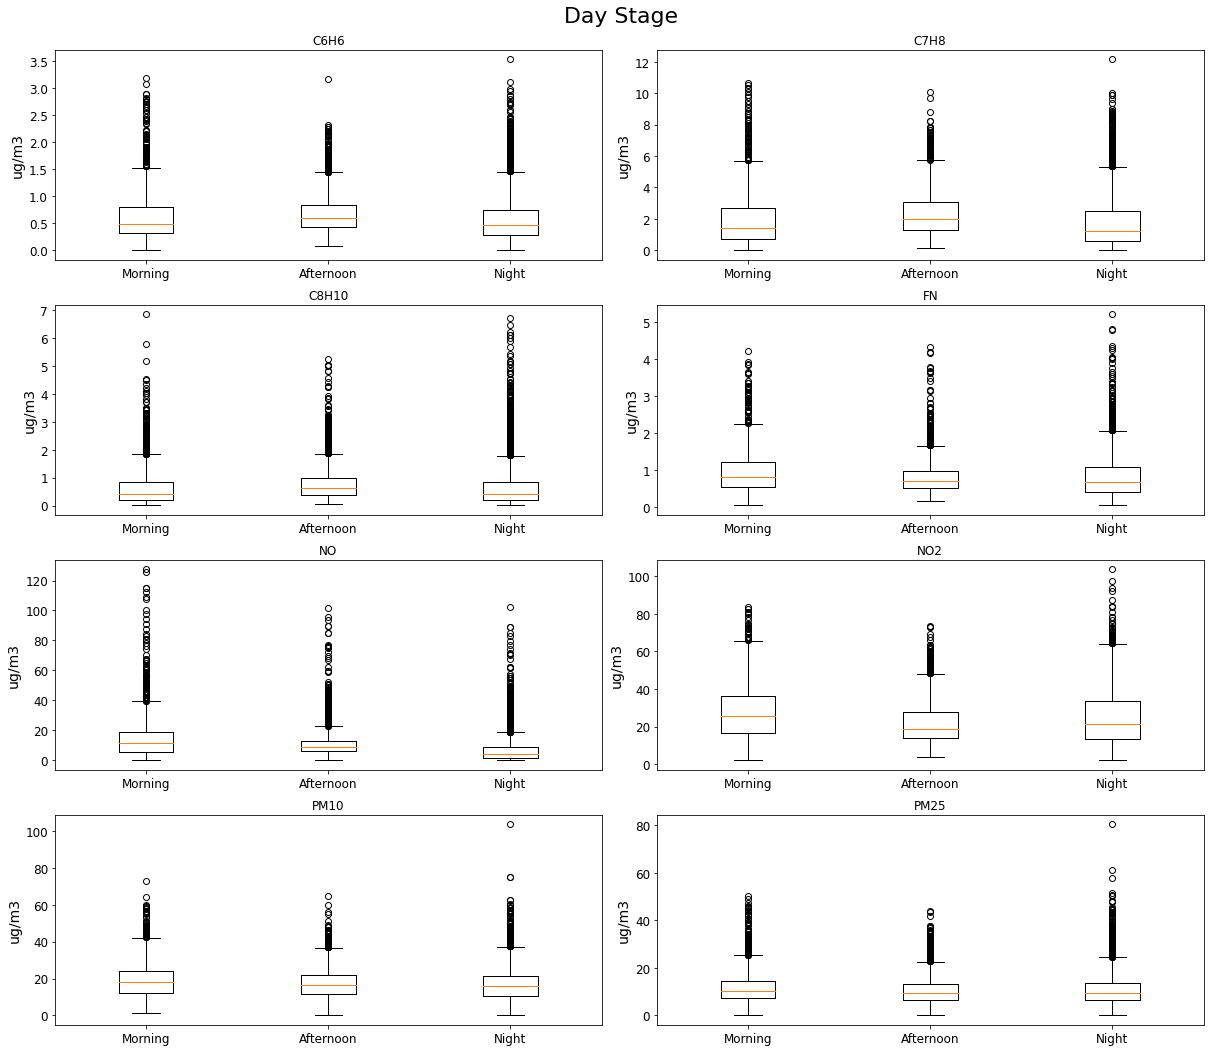

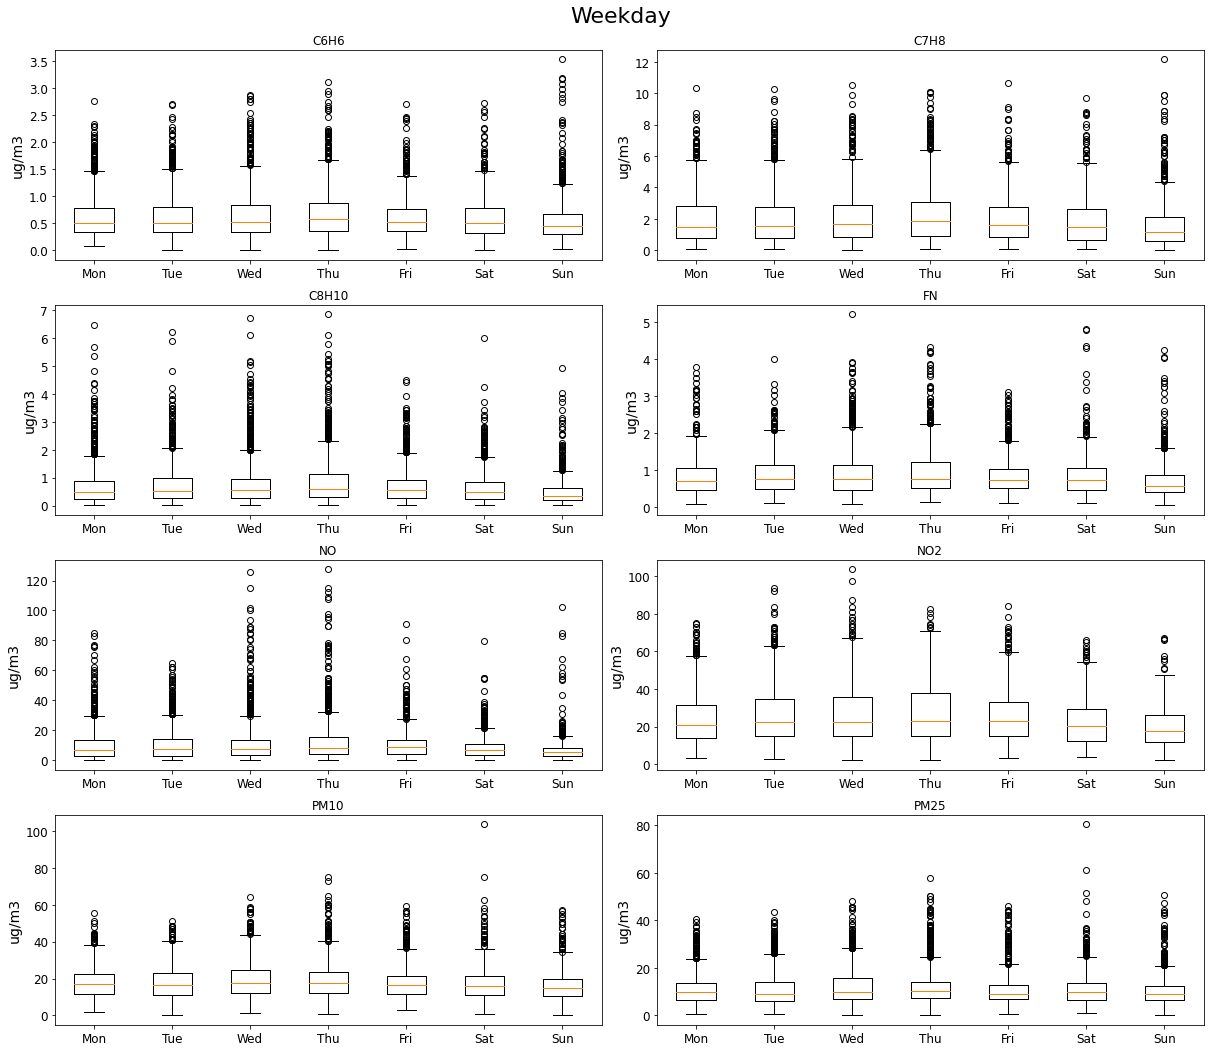

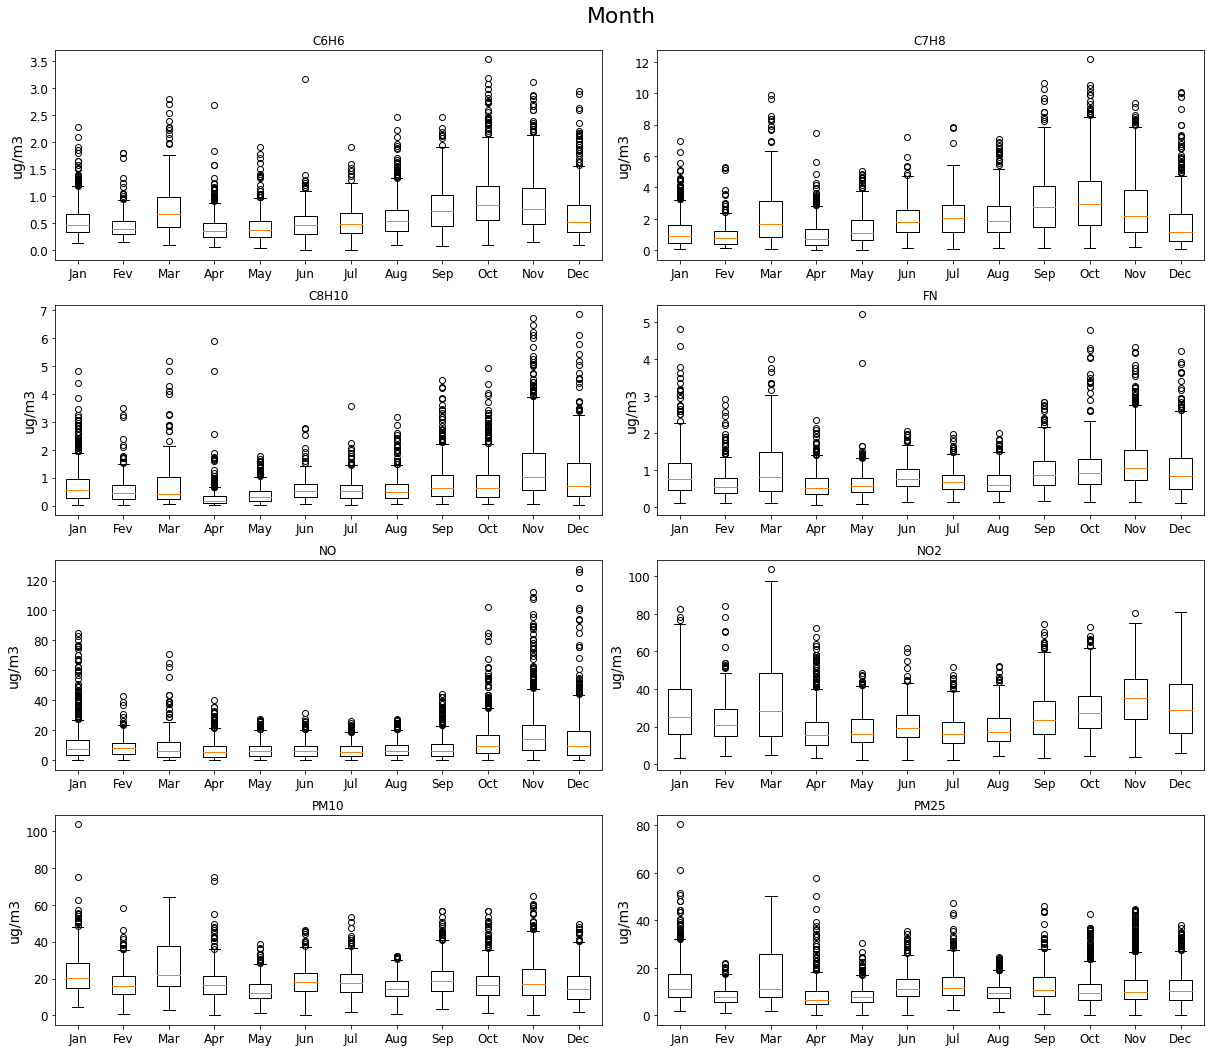

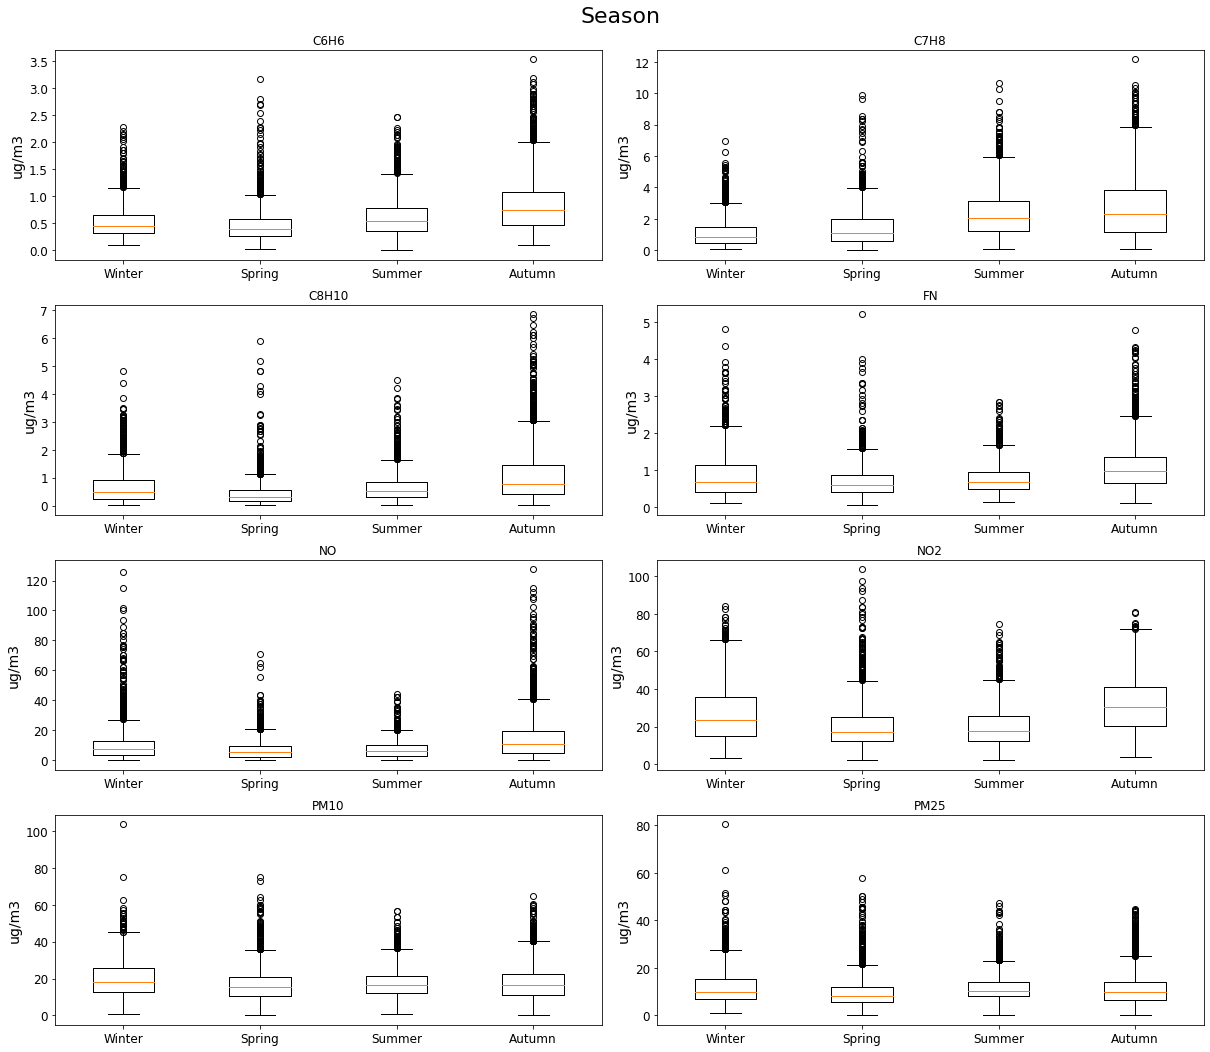

In [20]:
Boxplots_particles('Day Stage', ['Morning','Afternoon','Night'])
Boxplots_particles('Weekday', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])
Boxplots_particles('Month', ['Jan','Fev','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
Boxplots_particles('Season', ['Winter','Spring','Summer','Autumn'])

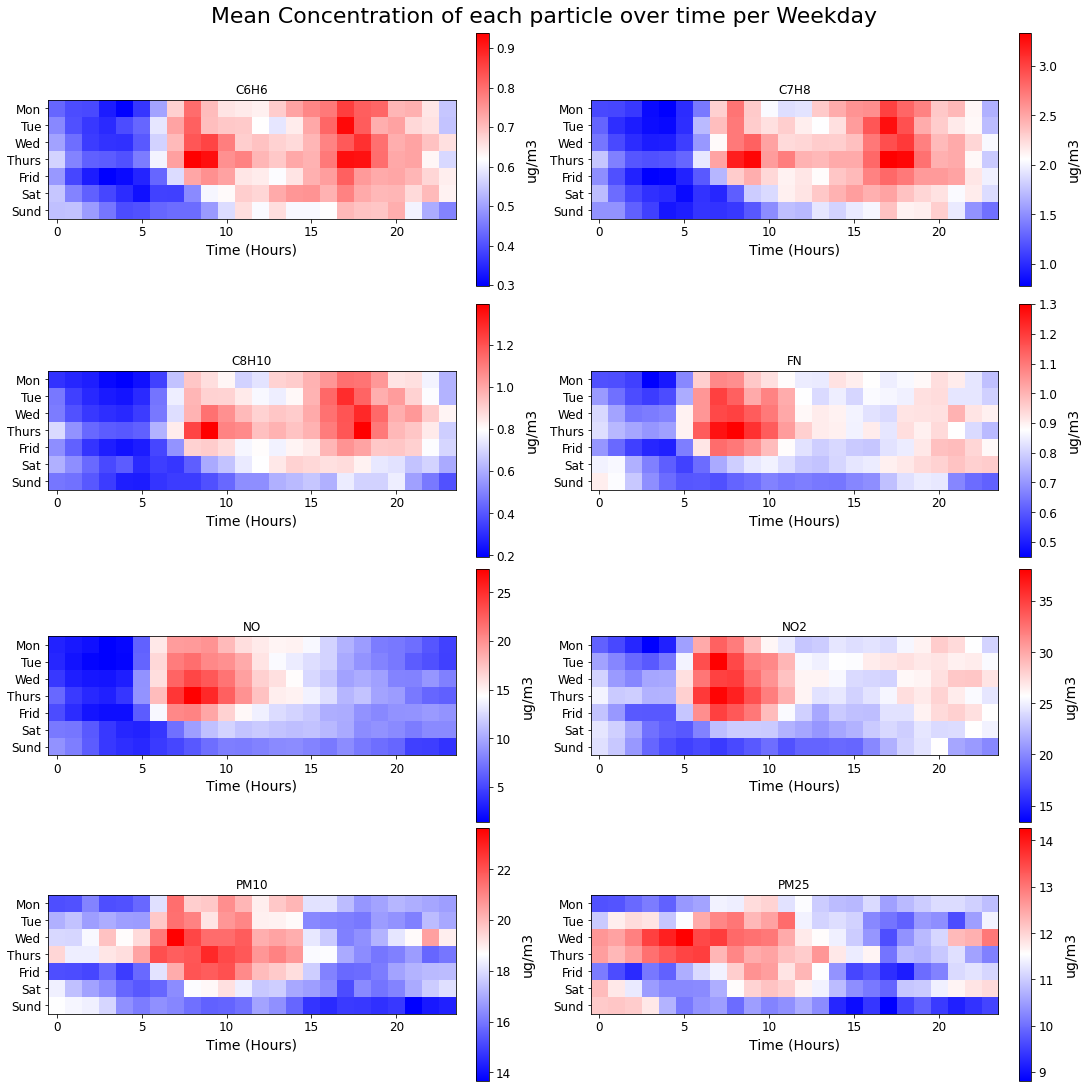

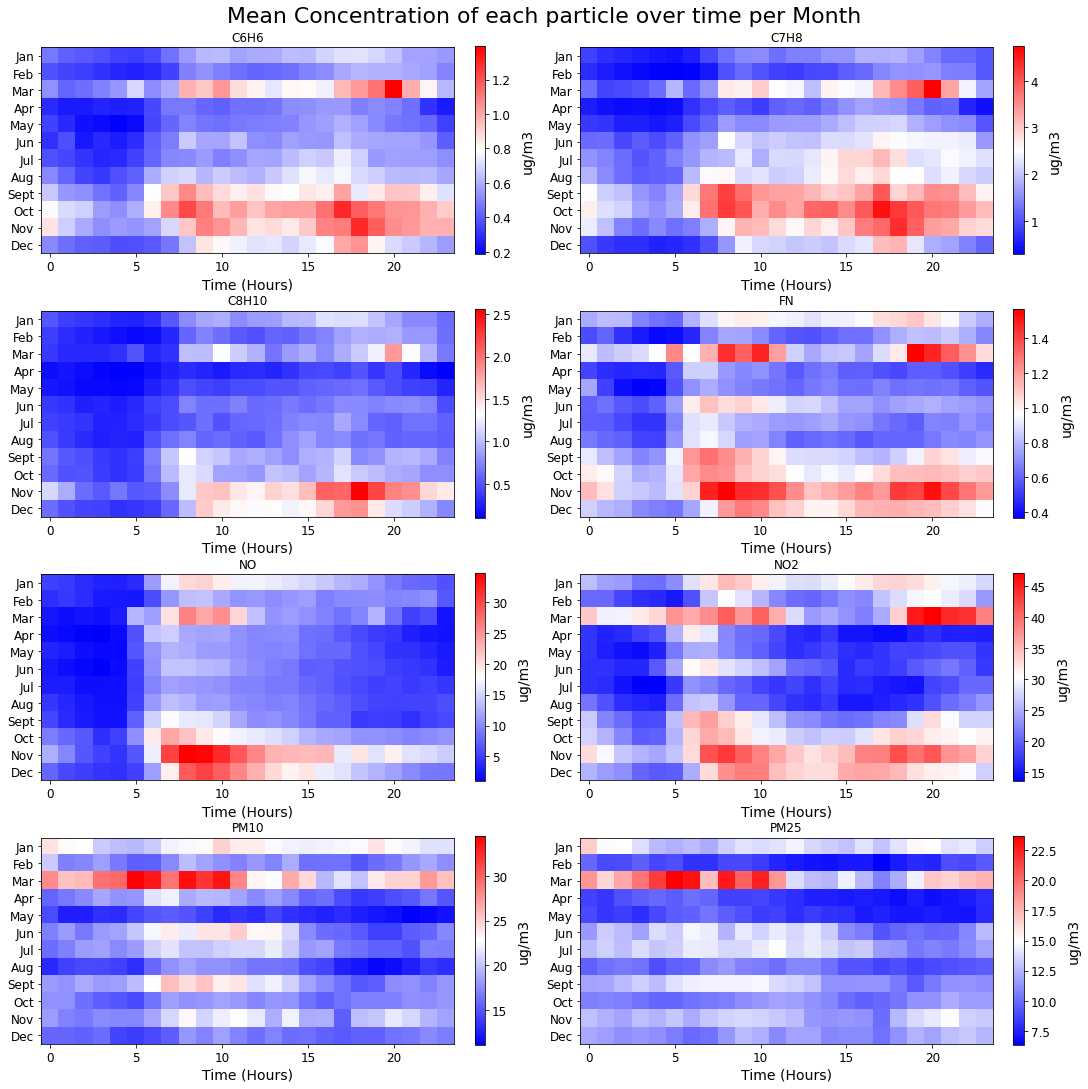

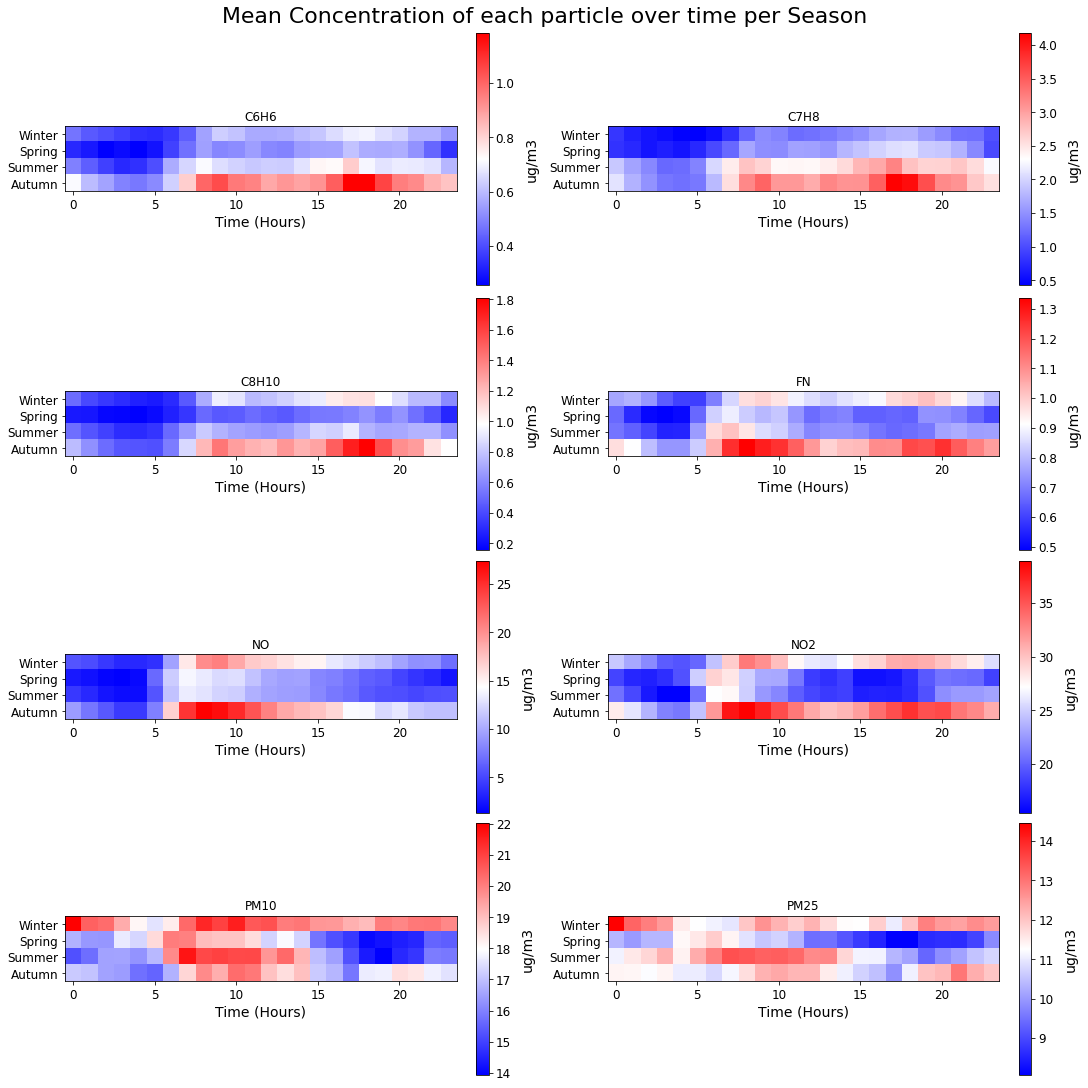

In [21]:
# Plots for the concentration of each particle over time
options = ["Weekday", "Month", "Season"]

data_all = Plots_particleConcentration_perHour(pollution_weather_dataset,
                                               Plot_lines = False,
                                               Plot_heatmap = True,
                                               metric = 'mean',
                                               options = options,
                                               title = "Mean Concentration of each particle over time per")

#### Plots analysis

**Day Stage**
<ul>
    <li>Regarding the stage of the day, the overall variation of each particle concentration varies among themselves according to the day stage. That is, some present higher concentrations in the afternoon, others present higher concentrations at night and in the morning, but no clear trend is common across all particles. However, in general, the distribution for the concentration of each particle is similar across day stages.</li>
</ul>

**Weekday**
<ul>
    <li>Through the analysis of the boxplots, we can observe that weekdays present higher concentration values for most particles, overall.  The trend is also noticeable in the mean concentration plots over time. This can be, in part, explained by the fact that more people are circulation for working/professional motives.</li>
    <li>Regarding the hours where the concentrations of the particles is higher, we can observe that the intervals between 5 and 10 o’clock, and 15 to 20 o’clock, are the ones where the mean concentration of the particles is higher. Once again, this can be, in part, explained by the fact more that people are circulation for working/professional motives, namely commuting to, or from work. Despite not having access to traffic data in the city, through the analysis of the traffic report available at <a href="https://www.tomtom.com/en_gb/traffic-index/amsterdam-traffic/">[22]</a>, we were able to observe that the hours with higher traffic intensity matched the intervals were we identified the highest mean concentrations for the particles. Therefore, we could establish that the increase in the particles’ concentration was directly correlated with the increase of traffic intensity. We can also observe that during the weekend, the mean concentration of each particle starts to rise at a latter hour of the day.</li>
</ul>

**Month and Season**
<ul>
    <li>As a generic trend, we can observe in both Season and Month boxplots’, that the concentration of particles is tendentially higher in Winter and Autumn months (for NO, NO2, C6H6, C7H8, FN). This can also be observed in the mean concentration plots over time.</li>
    <li>As it happened in the weekday plots’, we have also observed that the intervals between 5 and 10 o’clock, and 15 to 20 o’clock, are the ones where the concentration of the particles is higher.</li>
</ul>

#### Auto-correlation
In order to inspect about the seasonality in the data, we calculated the auto-correlation function for all the particle concentration values.

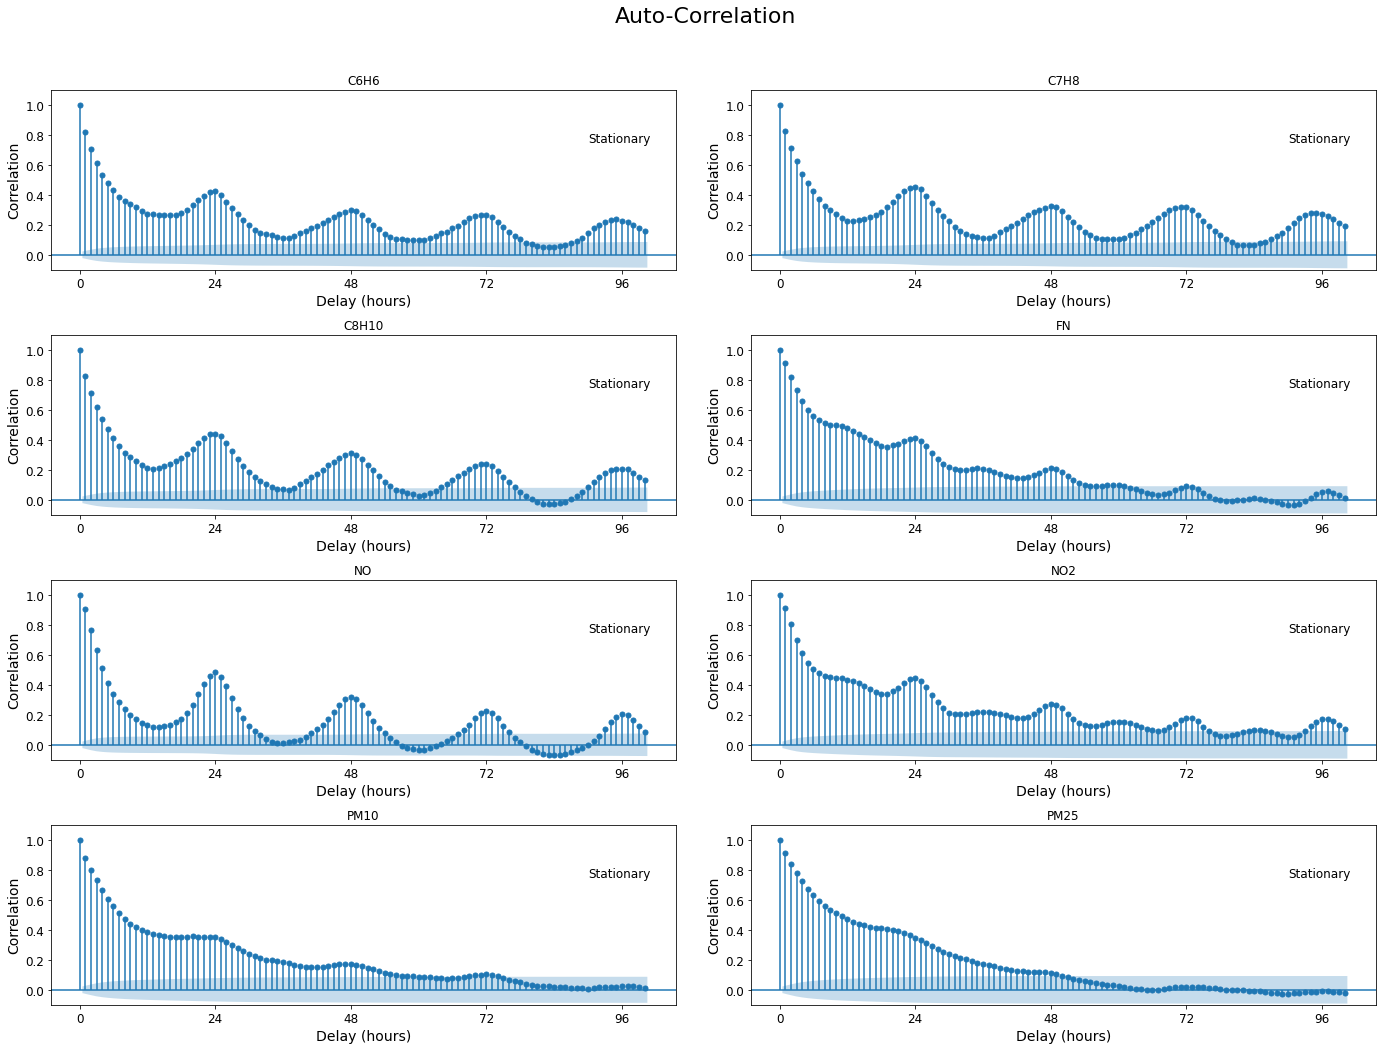

In [22]:
Plots_autocorrelation_particles(pollution_weather_dataset)

Auto-correlation plots show that there is a seasonality of 24 hours. This was already expected not only by analysing the previous plots but also because the day-to-day routines of the population are similar over the days. Furthermore, using Dickey-Fuller statistical tests we cannot reject the null hypotheses (series is stationary).

## Prepare the data to develop the explainable prediction models

### Evaluate correlation between the values present in the dataset

<AxesSubplot:>

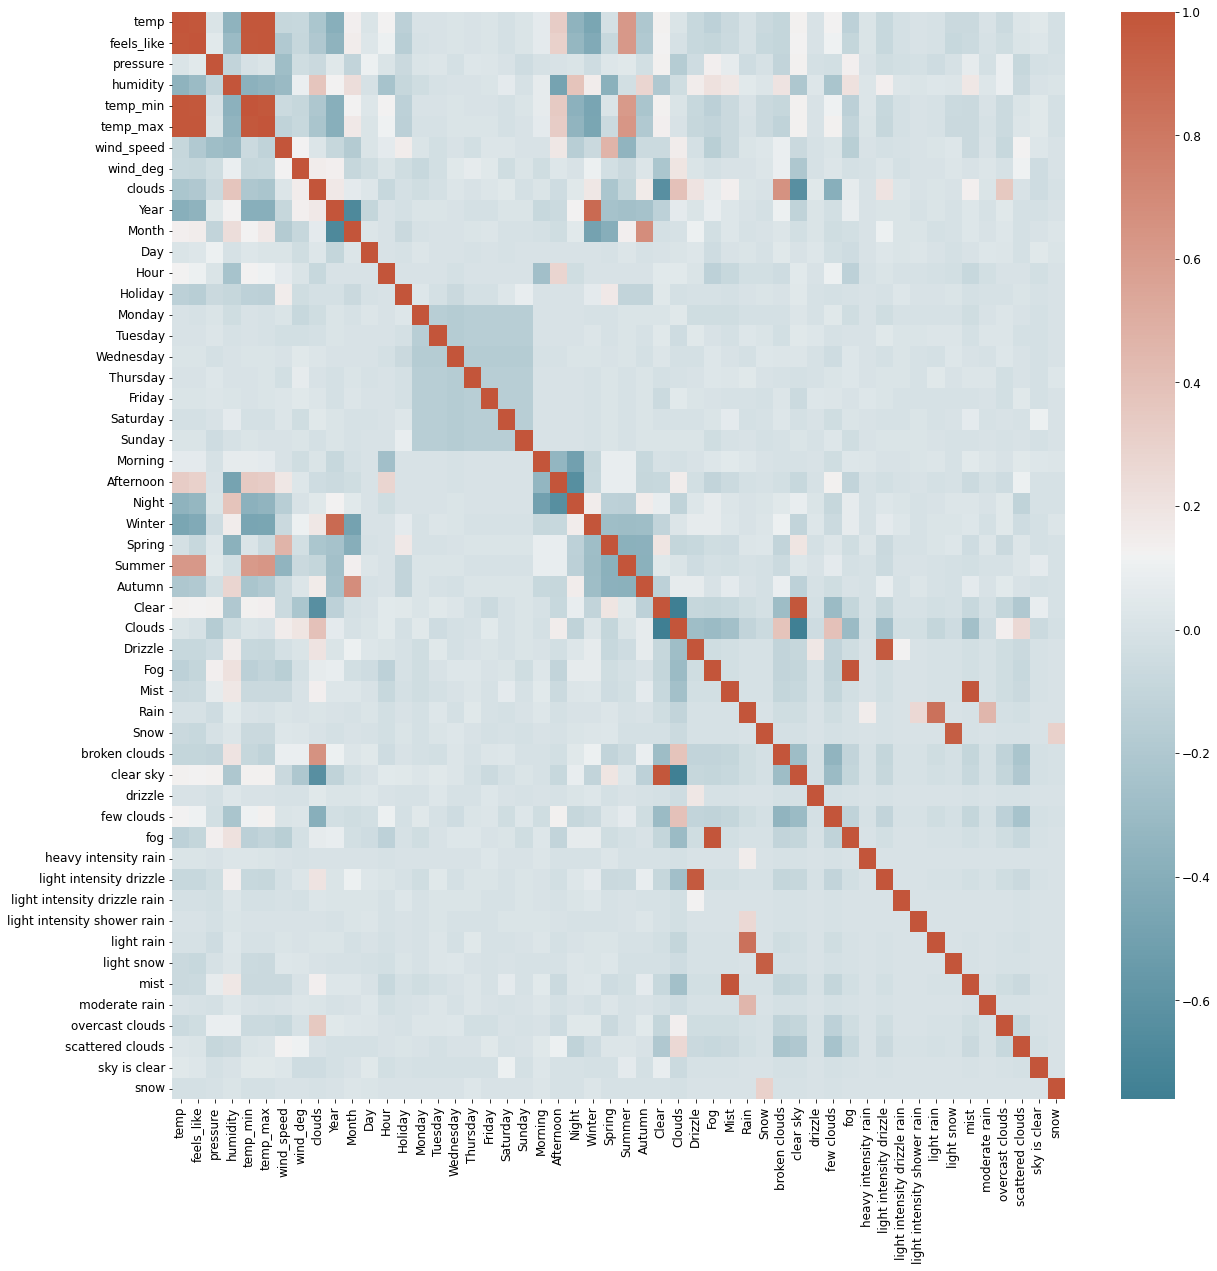

In [23]:
# Indexes of features and labels (concentration values)
number_columns = pollution_weather_dataset.shape[1]
feature_columns = np.concatenate((np.arange(0,9),np.arange(17,22),np.arange(23,30),
                                  np.arange(31,34),np.arange(35,number_columns)))
labels_columns = np.arange(9,17)

# Correlation matrix
corr_values = pollution_weather_dataset.iloc[:,feature_columns].corr().round(decimals=2)

fig, ax = plt.subplots(figsize=(20,20))        

sns.heatmap(corr_values, xticklabels=corr_values.columns,
            yticklabels=corr_values.columns, annot=False,
            cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)

Correlation matrix does not present any strong correlation between any feature and the concentration values. Therefore, we decided to not discard any feature at this point.

### Split dataset in training and test sets

In [24]:
# Test set with 3 months
pollution_weather_train_3_month = pollution_weather_dataset.loc[:'2021-11-15']
pollution_weather_test_3_month = pollution_weather_dataset.loc['2021-11-16':]

# Test set with 1 month
pollution_weather_train_1_month = pollution_weather_dataset.loc[:'2022-01-15']
pollution_weather_test_1_month = pollution_weather_dataset.loc['2022-01-16':]

# Test set with 1 week
pollution_weather_train_1_week = pollution_weather_dataset.loc[:'2022-02-08']
pollution_weather_test_1_week = pollution_weather_dataset.loc['2022-02-09':]

X_train_3_month,X_test_3_month,y_train_3_month,y_test_3_month = divide_features_labels(pollution_weather_train_3_month,pollution_weather_test_3_month,feature_columns,labels_columns)
X_train_1_month,X_test_1_month,y_train_1_month,y_test_1_month = divide_features_labels(pollution_weather_train_1_month,pollution_weather_test_1_month,feature_columns,labels_columns)
X_train_1_week,X_test_1_week,y_train_1_week,y_test_1_week = divide_features_labels(pollution_weather_train_1_week,pollution_weather_test_1_week,feature_columns,labels_columns)

### Split data by particle and remove NaNs

In [25]:
# Training Set
X_train_3_month_c6h6,X_train_3_month_c7h8,X_train_3_month_c8h10,X_train_3_month_fn,X_train_3_month_no,X_train_3_month_no2,X_train_3_month_pm10,X_train_3_month_pm25,\
y_train_3_month_c6h6,y_train_3_month_c7h8,y_train_3_month_c8h10,y_train_3_month_fn,y_train_3_month_no,y_train_3_month_no2,y_train_3_month_pm10,y_train_3_month_pm25 = split_data_particle(X_train_3_month,y_train_3_month)

X_train_1_month_c6h6,X_train_1_month_c7h8,X_train_1_month_c8h10,X_train_1_month_fn,X_train_1_month_no,X_train_1_month_no2,X_train_1_month_pm10,X_train_1_month_pm25,\
y_train_1_month_c6h6,y_train_1_month_c7h8,y_train_1_month_c8h10,y_train_1_month_fn,y_train_1_month_no,y_train_1_month_no2,y_train_1_month_pm10,y_train_1_month_pm25 = split_data_particle(X_train_1_month,y_train_1_month)

X_train_1_week_c6h6,X_train_1_week_c7h8,X_train_1_week_c8h10,X_train_1_week_fn,X_train_1_week_no,X_train_1_week_no2,X_train_1_week_pm10,X_train_1_week_pm25,\
y_train_1_week_c6h6,y_train_1_week_c7h8,y_train_1_week_c8h10,y_train_1_week_fn,y_train_1_week_no,y_train_1_week_no2,y_train_1_week_pm10,y_train_1_week_pm25 = split_data_particle(X_train_1_week,y_train_1_week)

# Test Set
X_test_3_month_c6h6,X_test_3_month_c7h8,X_test_3_month_c8h10,X_test_3_month_fn,X_test_3_month_no,X_test_3_month_no2,X_test_3_month_pm10,X_test_3_month_pm25,\
y_test_3_month_c6h6,y_test_3_month_c7h8,y_test_3_month_c8h10,y_test_3_month_fn,y_test_3_month_no,y_test_3_month_no2,y_test_3_month_pm10,y_test_3_month_pm25 = split_data_particle(X_test_3_month,y_test_3_month)

X_test_1_month_c6h6,X_test_1_month_c7h8,X_test_1_month_c8h10,X_test_1_month_fn,X_test_1_month_no,X_test_1_month_no2,X_test_1_month_pm10,X_test_1_month_pm25,\
y_test_1_month_c6h6,y_test_1_month_c7h8,y_test_1_month_c8h10,y_test_1_month_fn,y_test_1_month_no,y_test_1_month_no2,y_test_1_month_pm10,y_test_1_month_pm25 = split_data_particle(X_test_1_month,y_test_1_month)

X_test_1_week_c6h6,X_test_1_week_c7h8,X_test_1_week_c8h10,X_test_1_week_fn,X_test_1_week_no,X_test_1_week_no2,X_test_1_week_pm10,X_test_1_week_pm25,\
y_test_1_week_c6h6,y_test_1_week_c7h8,y_test_1_week_c8h10,y_test_1_week_fn,y_test_1_week_no,y_test_1_week_no2,y_test_1_week_pm10,y_test_1_week_pm25 = split_data_particle(X_test_1_week,y_test_1_week)

## Development of the explainable prediction models

For developing our models we performed a grid-search in order to find the best hyperparameters for each regression model. We performed this grid-search locally in our computers. The code use to do this task is available in the <b>Appendix</b>.

In [26]:
# ML Models

X_trains_3_month = [X_train_3_month_c6h6,X_train_3_month_c7h8,X_train_3_month_c8h10,X_train_3_month_fn,X_train_3_month_no,X_train_3_month_no2,X_train_3_month_pm10,X_train_3_month_pm25]
y_trains_3_month = [y_train_3_month_c6h6,y_train_3_month_c7h8,y_train_3_month_c8h10,y_train_3_month_fn,y_train_3_month_no,y_train_3_month_no2,y_train_3_month_pm10,y_train_3_month_pm25]

X_trains_1_month = [X_train_1_month_c6h6,X_train_1_month_c7h8,X_train_1_month_c8h10,X_train_1_month_fn,X_train_1_month_no,X_train_1_month_no2,X_train_1_month_pm10,X_train_1_month_pm25]
y_trains_1_month = [y_train_1_month_c6h6,y_train_1_month_c7h8,y_train_1_month_c8h10,y_train_1_month_fn,y_train_1_month_no,y_train_1_month_no2,y_train_1_month_pm10,y_train_1_month_pm25]

X_trains_1_week = [X_train_1_week_c6h6,X_train_1_week_c7h8,X_train_1_week_c8h10,X_train_1_week_fn,X_train_1_week_no,X_train_1_week_no2,X_train_1_week_pm10,X_train_1_week_pm25]
y_trains_1_week = [y_train_1_week_c6h6,y_train_1_week_c7h8,y_train_1_week_c8h10,y_train_1_week_fn,y_train_1_week_no,y_train_1_week_no2,y_train_1_week_pm10,y_train_1_week_pm25]

hyperparameters_3_month = [[256,512,256,256,256,512,512,256],[None,None,None,None,None,None,None,None]]
hyperparameters_1_month = [[256,512,256,128,256,512,256,512],[None,None,None,None,None,None,None,None]]
hyperparameters_1_week = [[128,512,512,256,512,64,16,64],[None,None,None,None,None,None,None,None]]

print('Training for 3 Months...')
rf_model_3_month_c6h6,rf_model_3_month_c7h8,rf_model_3_month_c8h10,rf_model_3_month_fn,rf_model_3_month_no,rf_model_3_month_no2,rf_model_3_month_pm10,rf_model_3_month_pm25 = train_rf_models(hyperparameters_3_month,X_trains_3_month,y_trains_3_month)
print('Training for 1 Month...')
rf_model_1_month_c6h6,rf_model_1_month_c7h8,rf_model_1_month_c8h10,rf_model_1_month_fn,rf_model_1_month_no,rf_model_1_month_no2,rf_model_1_month_pm10,rf_model_1_month_pm25 = train_rf_models(hyperparameters_1_month,X_trains_1_month,y_trains_1_month)
print('Training for 1 Week...')
rf_model_1_week_c6h6,rf_model_1_week_c7h8,rf_model_1_week_c8h10,rf_model_1_week_fn,rf_model_1_week_no,rf_model_1_week_no2,rf_model_1_week_pm10,rf_model_1_week_pm25 = train_rf_models(hyperparameters_1_week,X_trains_1_week,y_trains_1_week)

Training for 3 Months...
Training for 1 Month...
Training for 1 Week...


## Evaluating and understanding of the predictions obtained from the explainable prediction models

In [27]:
# Predictions
print('Predicting...')
rf_models_3_month = [rf_model_3_month_c6h6,rf_model_3_month_c7h8,rf_model_3_month_c8h10,rf_model_3_month_fn,rf_model_3_month_no,rf_model_3_month_no2,rf_model_3_month_pm10,rf_model_3_month_pm25]
rf_models_1_month = [rf_model_1_month_c6h6,rf_model_1_month_c7h8,rf_model_1_month_c8h10,rf_model_1_month_fn,rf_model_1_month_no,rf_model_1_month_no2,rf_model_1_month_pm10,rf_model_1_month_pm25]
rf_models_1_week = [rf_model_1_week_c6h6,rf_model_1_week_c7h8,rf_model_1_week_c8h10,rf_model_1_week_fn,rf_model_1_week_no,rf_model_1_week_no2,rf_model_1_week_pm10,rf_model_1_week_pm25]

X_tests_3_month = [X_test_3_month_c6h6,X_test_3_month_c7h8,X_test_3_month_c8h10,X_test_3_month_fn,X_test_3_month_no,X_test_3_month_no2,X_test_3_month_pm10,X_test_3_month_pm25]

X_tests_1_month = [X_test_1_month_c6h6,X_test_1_month_c7h8,X_test_1_month_c8h10,X_test_1_month_fn,X_test_1_month_no,X_test_1_month_no2,X_test_1_month_pm10,X_test_1_month_pm25]

X_tests_1_week = [X_test_1_week_c6h6,X_test_1_week_c7h8,X_test_1_week_c8h10,X_test_1_week_fn,X_test_1_week_no,X_test_1_week_no2,X_test_1_week_pm10,X_test_1_week_pm25]

y_pred_3_month_c6h6,y_pred_3_month_c7h8,y_pred_3_month_c8h10,y_pred_3_month_fn,y_pred_3_month_no,y_pred_3_month_no2,y_pred_3_month_pm10,y_pred_3_month_pm25 = predict_all_particles(rf_models_3_month,X_tests_3_month)
y_pred_1_month_c6h6,y_pred_1_month_c7h8,y_pred_1_month_c8h10,y_pred_1_month_fn,y_pred_1_month_no,y_pred_1_month_no2,y_pred_1_month_pm10,y_pred_1_month_pm25 = predict_all_particles(rf_models_1_month,X_tests_1_month)
y_pred_1_week_c6h6,y_pred_1_week_c7h8,y_pred_1_week_c8h10,y_pred_1_week_fn,y_pred_1_week_no,y_pred_1_week_no2,y_pred_1_week_pm10,y_pred_1_week_pm25 = predict_all_particles(rf_models_1_week,X_tests_1_week)

print('----Relative Root Mean Squared Error (3 Months)----')
print(f'C6H6: {np.round(np.sqrt(mean_squared_error(y_test_3_month_c6h6,y_pred_3_month_c6h6))/np.mean(y_test_3_month_c6h6)*100,2)}%')
print(f'C7H8: {np.round(np.sqrt(mean_squared_error(y_test_3_month_c7h8,y_pred_3_month_c7h8))/np.mean(y_test_3_month_c7h8)*100,2)}%')
print(f'C8H10: {np.round(np.sqrt(mean_squared_error(y_test_3_month_c8h10,y_pred_3_month_c8h10))/np.mean(y_test_3_month_c8h10)*100,2)}%')
print(f'FN: {np.round(np.sqrt(mean_squared_error(y_test_3_month_fn,y_pred_3_month_fn))/np.mean(y_test_3_month_fn)*100,2)}%')
print(f'NO: {np.round(np.sqrt(mean_squared_error(y_test_3_month_no,y_pred_3_month_no))/np.mean(y_test_3_month_no)*100,2)}%')
print(f'NO2: {np.round(np.sqrt(mean_squared_error(y_test_3_month_no2,y_pred_3_month_no2))/np.mean(y_test_3_month_no2)*100,2)}%')
print(f'PM10: {np.round(np.sqrt(mean_squared_error(y_test_3_month_pm10,y_pred_3_month_pm10))/np.mean(y_test_3_month_pm10)*100,2)}%')
print(f'PM25: {np.round(np.sqrt(mean_squared_error(y_test_3_month_pm25,y_pred_3_month_pm25))/np.mean(y_test_3_month_pm25)*100,2)}%')

print('----Relative Root Mean Squared Error (1 Month)----')
print(f'C6H6: {np.round(np.sqrt(mean_squared_error(y_test_1_month_c6h6,y_pred_1_month_c6h6))/np.mean(y_test_1_month_c6h6)*100,2)}%')
print(f'C7H8: {np.round(np.sqrt(mean_squared_error(y_test_1_month_c7h8,y_pred_1_month_c7h8))/np.mean(y_test_1_month_c7h8)*100,2)}%')
print(f'C8H10: {np.round(np.sqrt(mean_squared_error(y_test_1_month_c8h10,y_pred_1_month_c8h10))/np.mean(y_test_1_month_c8h10)*100,2)}%')
print(f'FN: {np.round(np.sqrt(mean_squared_error(y_test_1_month_fn,y_pred_1_month_fn))/np.mean(y_test_1_month_fn)*100,2)}%')
print(f'NO: {np.round(np.sqrt(mean_squared_error(y_test_1_month_no,y_pred_1_month_no))/np.mean(y_test_1_month_no)*100,2)}%')
print(f'NO2: {np.round(np.sqrt(mean_squared_error(y_test_1_month_no2,y_pred_1_month_no2))/np.mean(y_test_1_month_no2)*100,2)}%')
print(f'PM10: {np.round(np.sqrt(mean_squared_error(y_test_1_month_pm10,y_pred_1_month_pm10))/np.mean(y_test_1_month_pm10)*100,2)}%')
print(f'PM25: {np.round(np.sqrt(mean_squared_error(y_test_1_month_pm25,y_pred_1_month_pm25))/np.mean(y_test_1_month_pm25)*100,2)}%')

print('----Relative Root Mean Squared Error (1 Week)----')
print(f'C6H6: {np.round(np.sqrt(mean_squared_error(y_test_1_week_c6h6,y_pred_1_week_c6h6))/np.mean(y_test_1_week_c6h6)*100,2)}%')
print(f'C7H8: {np.round(np.sqrt(mean_squared_error(y_test_1_week_c7h8,y_pred_1_week_c7h8))/np.mean(y_test_1_week_c7h8)*100,2)}%')
print(f'C8H10: {np.round(np.sqrt(mean_squared_error(y_test_1_week_c8h10,y_pred_1_week_c8h10))/np.mean(y_test_1_week_c8h10)*100,2)}%')
print(f'FN: {np.round(np.sqrt(mean_squared_error(y_test_1_week_fn,y_pred_1_week_fn))/np.mean(y_test_1_week_fn)*100,2)}%')
print(f'NO: {np.round(np.sqrt(mean_squared_error(y_test_1_week_no,y_pred_1_week_no))/np.mean(y_test_1_week_no)*100,2)}%')
print(f'NO2: {np.round(np.sqrt(mean_squared_error(y_test_1_week_no2,y_pred_1_week_no2))/np.mean(y_test_1_week_no2)*100,2)}%')
print(f'PM10: {np.round(np.sqrt(mean_squared_error(y_test_1_week_pm10,y_pred_1_week_pm10))/np.mean(y_test_1_week_pm10)*100,2)}%')
print(f'PM25: {np.round(np.sqrt(mean_squared_error(y_test_1_week_pm25,y_pred_1_week_pm25))/np.mean(y_test_1_week_pm25)*100,2)}%')

Predicting...
----Relative Root Mean Squared Error (3 Months)----
C6H6: 92.46%
C7H8: 128.5%
C8H10: 94.77%
FN: 76.87%
NO: 115.65%
NO2: 66.93%
PM10: 61.29%
PM25: 95.41%
----Relative Root Mean Squared Error (1 Month)----
C6H6: 67.8%
C7H8: 84.04%
C8H10: 87.7%
FN: 100.43%
NO: 109.45%
NO2: 70.3%
PM10: 48.71%
PM25: 68.98%
----Relative Root Mean Squared Error (1 Week)----
C6H6: 39.29%
C7H8: 63.99%
C8H10: 57.9%
FN: 50.2%
NO: 51.73%
NO2: 36.04%
PM10: 64.26%
PM25: 54.61%


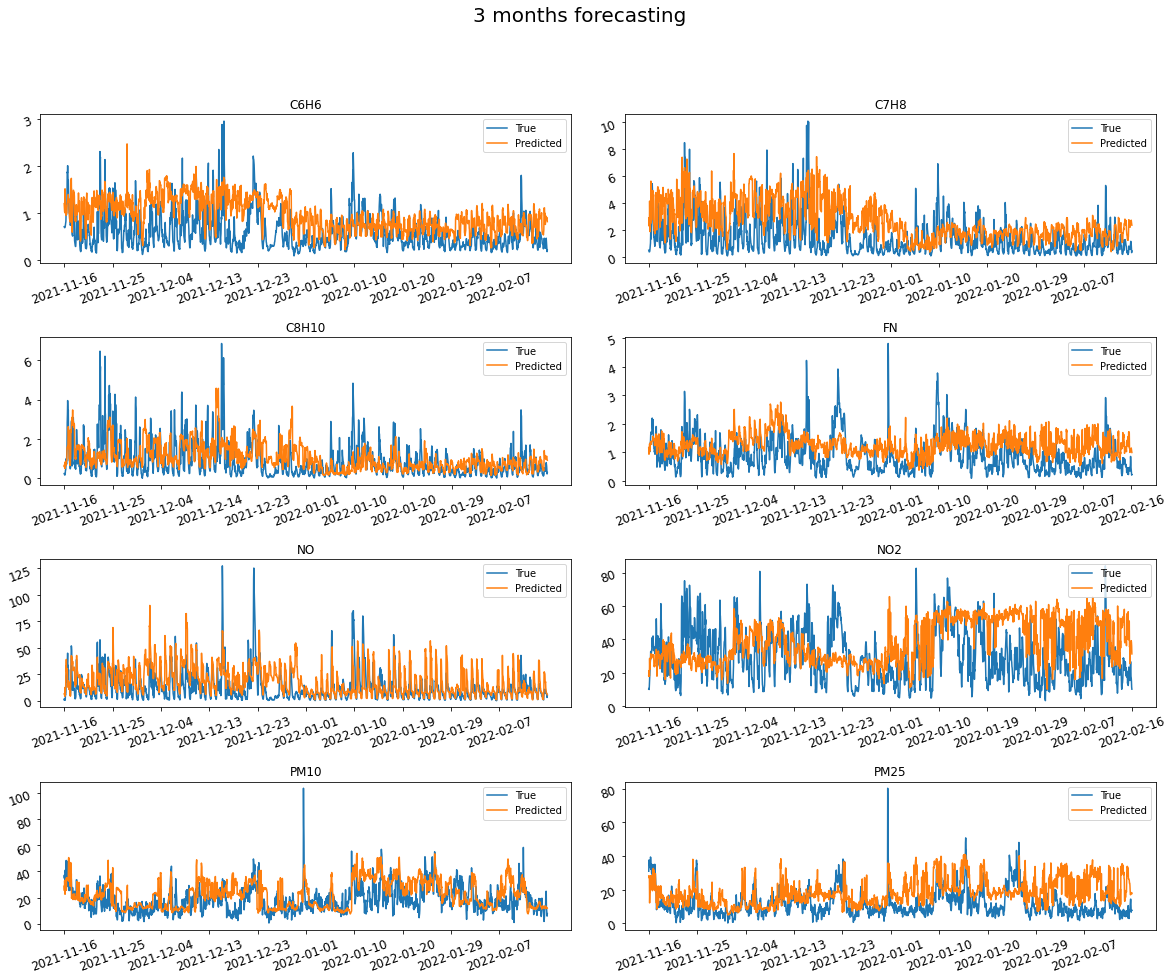

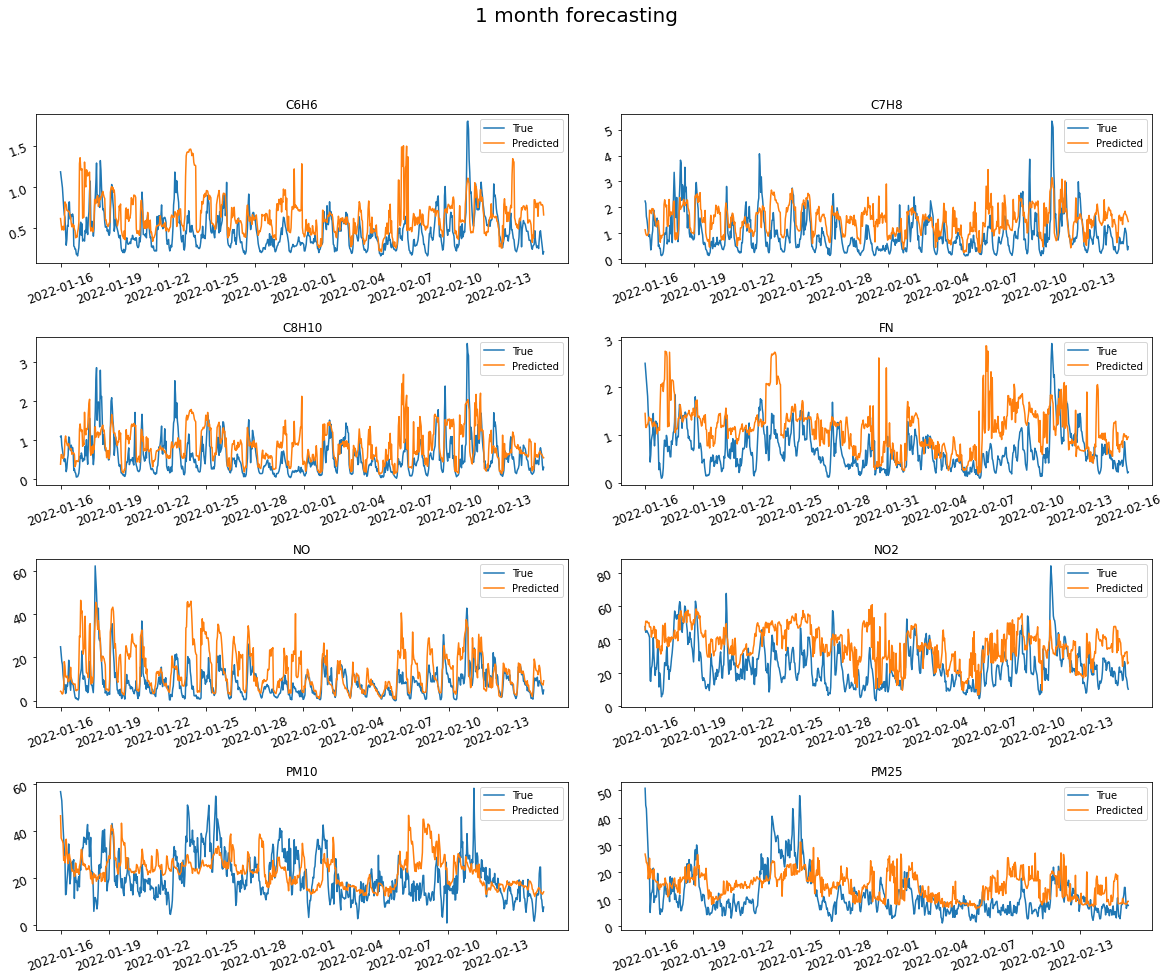

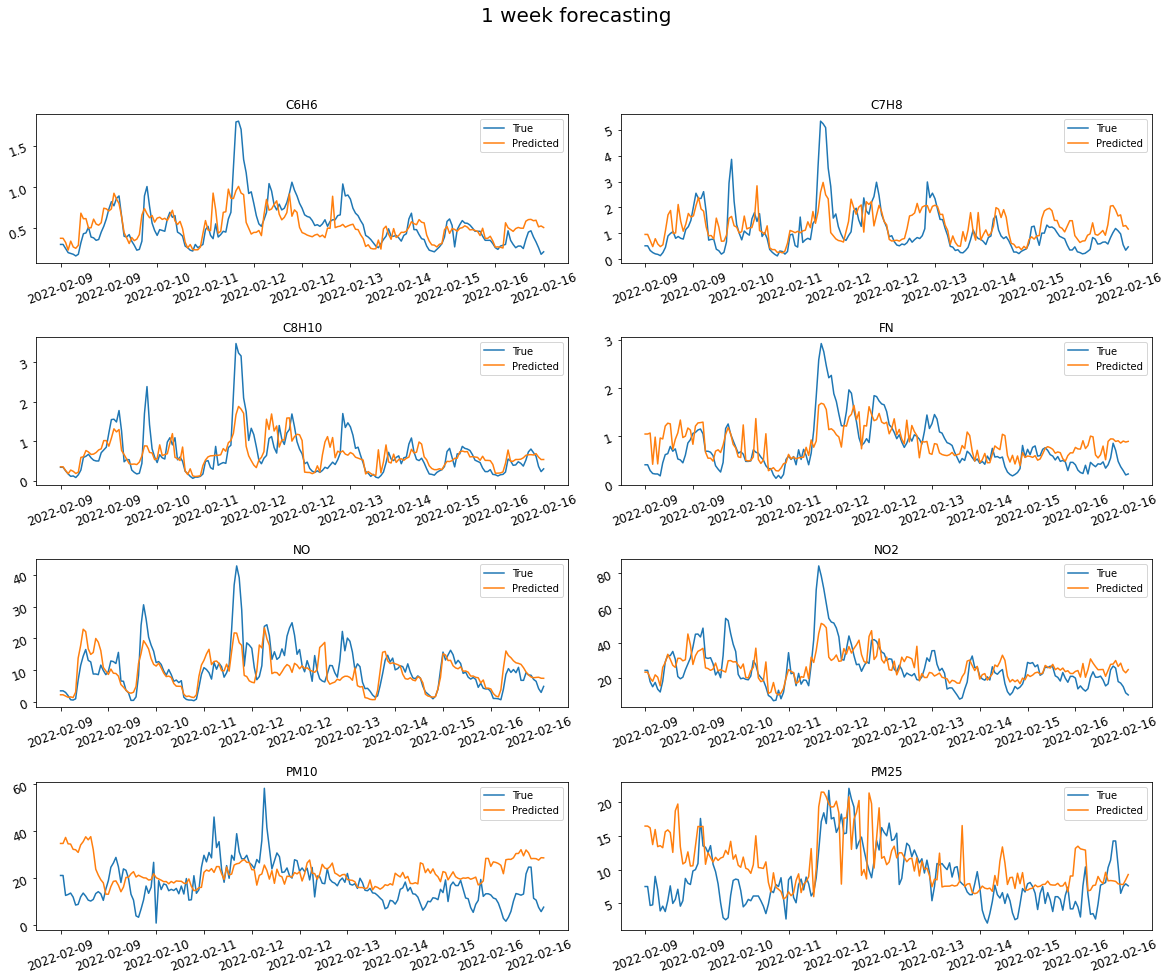

In [28]:
particles_names = ['C6H6','C7H8','C8H10','FN','NO','NO2','PM10','PM25']
# 3 months forecasting
dates_c6h6,dates_c7h8,dates_c8h10,dates_fn,dates_no,dates_no2,dates_pm10,dates_pm25 = get_non_nan_dates(pollution_weather_test_3_month,y_test_3_month)

models_3_months = {'C6H6': [y_test_3_month_c6h6, y_pred_3_month_c6h6, dates_c6h6], 'C7H8': [y_test_3_month_c7h8, y_pred_3_month_c7h8, dates_c7h8, dates_fn], 
                  'C8H10': [y_test_3_month_c8h10, y_pred_3_month_c8h10, dates_c8h10], 'FN': [ y_test_3_month_fn, y_pred_3_month_fn, dates_fn], 
                  'NO': [y_test_3_month_no, y_pred_3_month_no, dates_no], 'NO2': [y_test_3_month_no2, y_pred_3_month_no2, dates_no2], 
                  'PM10': [y_test_3_month_pm10, y_pred_3_month_pm10, dates_pm10], 'PM25': [y_test_3_month_pm25, y_pred_3_month_pm25, dates_pm25], 
                  'forecasting': '3 months forecasting'}
plot_trueVSpredicted(models_3_months, particles_names)

# 1 month forecasting
dates_c6h6,dates_c7h8,dates_c8h10,dates_fn,dates_no,dates_no2,dates_pm10,dates_pm25 = get_non_nan_dates(pollution_weather_test_1_month,y_test_1_month)
models_1_month = {'C6H6': [y_test_1_month_c6h6, y_pred_1_month_c6h6, dates_c6h6], 'C7H8': [y_test_1_month_c7h8, y_pred_1_month_c7h8, dates_c7h8, dates_fn], 
                  'C8H10': [y_test_1_month_c8h10, y_pred_1_month_c8h10, dates_c8h10], 'FN': [ y_test_1_month_fn, y_pred_1_month_fn, dates_fn], 
                  'NO': [y_test_1_month_no, y_pred_1_month_no, dates_no], 'NO2': [y_test_1_month_no2, y_pred_1_month_no2, dates_no2], 
                  'PM10': [y_test_1_month_pm10, y_pred_1_month_pm10, dates_pm10], 'PM25': [y_test_1_month_pm25, y_pred_1_month_pm25, dates_pm25], 
                  'forecasting': '1 month forecasting'}
plot_trueVSpredicted(models_1_month, particles_names)

# 1 week forecasting
dates_c6h6,dates_c7h8,dates_c8h10,dates_fn,dates_no,dates_no2,dates_pm10,dates_pm25 = get_non_nan_dates(pollution_weather_test_1_week,y_test_1_week)
models_1_week = {'C6H6': [y_test_1_week_c6h6, y_pred_1_week_c6h6, dates_c6h6], 'C7H8': [y_test_1_week_c7h8, y_pred_1_week_c7h8, dates_c7h8, dates_fn], 
                  'C8H10': [y_test_1_week_c8h10, y_pred_1_week_c8h10, dates_c8h10], 'FN': [ y_test_1_week_fn, y_pred_1_week_fn, dates_fn], 
                  'NO': [y_test_1_week_no, y_pred_1_week_no, dates_no], 'NO2': [y_test_1_week_no2, y_pred_1_week_no2, dates_no2], 
                  'PM10': [y_test_1_week_pm10, y_pred_1_week_pm10, dates_pm10], 'PM25': [y_test_1_week_pm25, y_pred_1_week_pm25, dates_pm25], 
                  'forecasting': '1 week forecasting'}
plot_trueVSpredicted(models_1_week, particles_names)

Results show that the error decreases with the decreasing of the forecasting period. This could happen because the smaller the forecast window is, the easier it is for the model to get the expected values since the changes that may occur in the data over the days should not be very significant.

### Explain the prediction models

Next, we will present the Shapley values for each pollutant prediction, for the prediction period of 1 week since it was the period which had the best results. These values present the importances and effects direction of the features for each period and pollutant using SHAP values (SHapley Additive exPlanations).

Permutation explainer: 192it [01:37,  1.76it/s]                         


SHAP Values: C6H6 - 1 Week


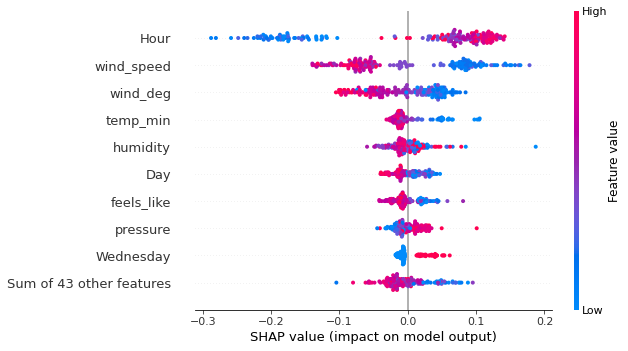

Permutation explainer: 192it [05:43,  1.85s/it]                         


SHAP Values: C7H8 - 1 Week


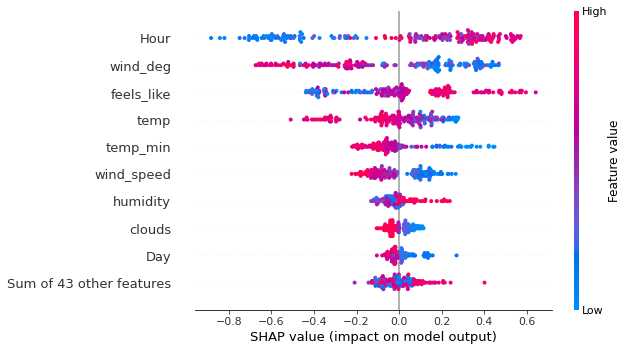

Permutation explainer: 192it [05:53,  1.90s/it]                         


SHAP Values: C8H10 - 1 Week


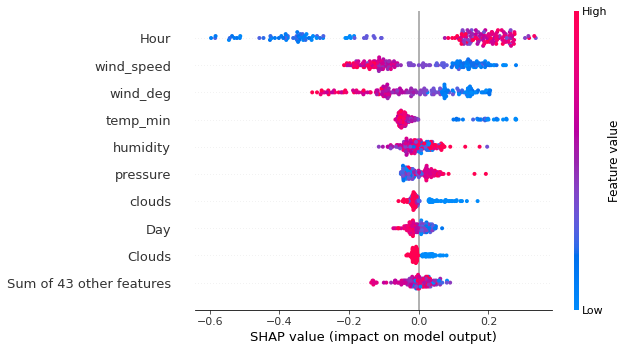

Permutation explainer: 194it [02:36,  1.16it/s]                         


SHAP Values: FN - 1 Week


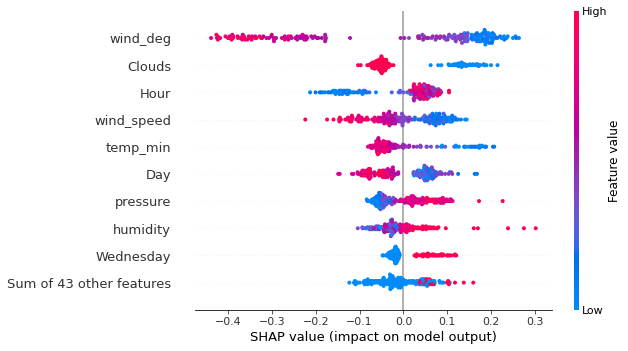

Permutation explainer: 194it [05:48,  1.85s/it]                         


SHAP Values: NO - 1 Week


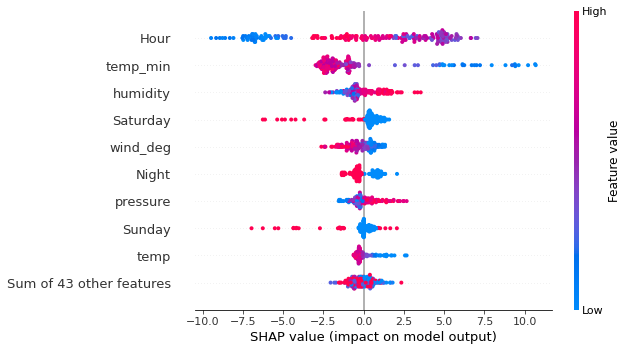

Permutation explainer: 194it [00:41,  3.52it/s]                         


SHAP Values: NO2 - 1 Week


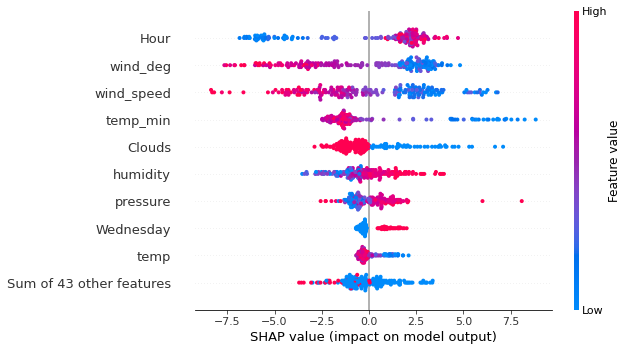

Permutation explainer: 194it [00:12,  3.31it/s]                         


SHAP Values: PM10 - 1 Week


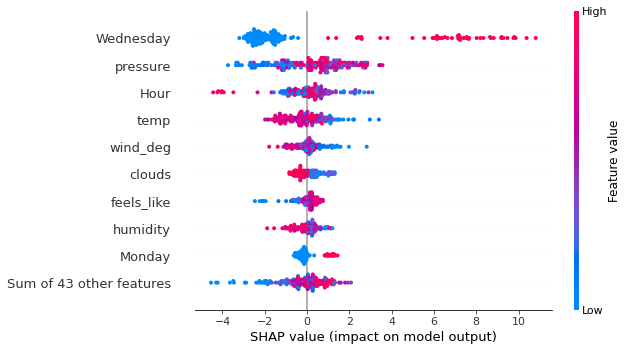

Permutation explainer: 194it [00:45,  3.33it/s]                         


SHAP Values: PM25 - 1 Week


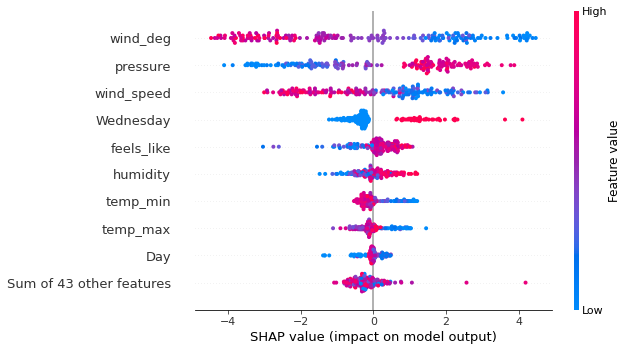

In [31]:
# 1 week forecasting
models_1_week = {'C6H6': rf_model_1_week_c6h6, 'C7H8': rf_model_1_week_c7h8, 'C8H10': rf_model_1_week_c8h10, 'FN':  rf_model_1_week_fn, 
          'NO': rf_model_1_week_no, 'NO2': rf_model_1_week_no2, 'PM10': rf_model_1_week_pm10, 'PM25': rf_model_1_week_pm25, 
          'forecasting': '1 week forecasting'}
plot_feature_importances(models_1_week, X_tests_1_week, particles_names)

The obtained feature importances agree with some previous conclusions. Analyzing the top 3 features (T3F) we can observe that the most important features overall are:

- 1-week forecasting: hour (T3F for 7/8 pollutants), wind_speed (T5F for 4/8 pollutants), wind_degree(T5F for 6/8 pollutants).

Furthermore, these plots present how the values of each feature contributed for the final forecasted concentration value. To make the analysing simpler, we only analyse the values of the most important features:

- Hour: Shap values show that the hours around the middle value are the ones that contributed the most for increasing the predicted value as it was already concluded in the previous analysis.

- Wind Degree: Shap values show that higher wind degree values lead to higher concentration values. This means that it is expected that the samples with higher concentration values are the ones when the wind come from the north. This could be explained by the high number of industry placed in this direction.

- Wind Speed: Shap values show that lower wind degree values lead to higher concentration values. This is in accordance to what we expected because if the wind speed is high the particles will tend to become more disperse (rare).

## Conclusion

1º Sazionalidade na [poluentes]

2º Peaks [poluentes] nas horas de ponta de ida para o trabalho e saída do trabalho

3º dias da semana Vs dias do fim de semana

4º Apos medidas de 2018, da cidade ter ficado mais verde, houve reduçao dos poluentes

5º Variaçoes dos poluentes Antes Covid  Vs 2 Lockdowns Vs Pós Covid

6º Correlações negativas altas e significativas entre [poluentes] e velocidade do vento // correlaçoes com outras estados do tempo existe tambem mas nao faz sentido com base na literatura.

### Sugestões:

1º Limitar acesso a veiculos em horas de ponta e direccionar para outras vias

2º Aumentar vegetação (arvores, etc) na rua e arredores ou adquirir arvores artificiais (BioUrban) que permite limpeza do ar e ao mesmo tempo nao contribiu para o aumento dos PM's

3º Controlar espectaculos que involvem fogo de artificio/etc e reencaminhar para locais mais na periferia da cidade (longe dessa rua)

4ª Incentivo mobilidade elétrica 






Medidas? falar algo aqi? **%"1) monitoring the structuring of programs and actions to control fixed and mobile sources of pollution; 2) establishment of artificial trees to capture more CO2; 3) ecological practices for energy saving and energy structure optimization 4) increase in carbon sinks, in addition to training human resources and generating new technologies."%** Nao sei

## References

[1] https://nltimes.nl/2017/11/28/polluting-scooters-banned-amsterdam-environmental-zone-next-year

[2] https://www.green-zones.eu/en/low-emission-zones/the-netherlands/amsterdam?fbclid=IwAR2d6DtTzd1pudhue2JrRvz3h3QwOOWSQxPH45pxxfcdCUTiU5gSJHwnzMU

[3] https://urbanaccessregulations.eu/countries-mainmenu-147/netherlands-mainmenu-88/amsterdam?fbclid=IwAR1Iqlmou1lhqxf4iAfWaB_LrtFwBbrkO8ihMC1C_URqfgF4O3UBiU6S6Fk

[4] https://dutchreview.com/traveling/cities/amsterdam/the-dutch-and-innovation-installing-blue-and-green-roofs-in-amsterdam/?fbclid=IwAR0V7YFz_4Ciew5WkNOZAY1s4eiKztZL06edcBhxx3kS5N53_c5i3r6BbNc

[5] https://www.the-travel-bunny.com/green-amsterdam-eco-capital/

[6] https://www.cancer.org/cancer/cancer-causes/benzene.html

[7] https://www.in.gov/idem/toxic/files/studies_toxwatch_toluene.pdf

[8] https://www.atsdr.cdc.gov/toxprofiles/tp110-c6.pdf

[9] https://www.canada.ca/en/health-canada/services/environmental-workplace-health/reports-publications/environmental-contaminants/ethylbenzene-health.html

[10] https://ntp.niehs.nih.gov/ntp/htdocs/chem_background/exsumpdf/nitrogentrifluoride_508.pdf

[11] https://www.britannica.com/science/nitric-oxide

[12] https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/nitrogen-dioxide-in-the-air

[13] https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air

[14] https://www.iqair.com/us/blog/air-quality/pm10

[15] https://www.sciencedirect.com/science/article/abs/pii/S1352231001001224

[16] https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air

[17] https://molekule.science/what-is-pm-2-5-and-how-can-you-reduce-your-exposure/

[18] https://www.nrdc.org/onearth/particulars-pm-25

[19] https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_Netherlands

[20] https://www.reuters.com/article/us-health-coronavirus-netherlands-protes-idUSKBN29M0EJ

[21] Kalter, M. J. O., Geurs, K. T., & Wismans, L. (2021). Post COVID-19 teleworking and car use intentions. Evidence from large scale GPS-tracking and survey data in the Netherlands. Transportation Research Interdisciplinary Perspectives, 12, 100498.

[22] https://www.tomtom.com/en_gb/traffic-index/amsterdam-traffic/

## Appendix

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

rf_hyperparameters = {'n_estimators':[16,32,64,128,256,512]}

scorer = make_scorer(mean_squared_error,greater_is_better=False)

grid_rf_model_c6h6 = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                               
grid_rf_model_c7h8 = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                  
grid_rf_model_c8h10 = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                  
grid_rf_model_fn = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                  
grid_rf_model_no = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                  
grid_rf_model_no2 = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                  
grid_rf_model_pm10 = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                  
grid_rf_model_pm25 = GridSearchCV(RandomForestRegressor(), rf_hyperparameters, cv=10,
                                  scoring=scorer,verbose=3,refit=False)
                                
grid_rf_model_c6h6.fit(X_train_c6h6,y_train_c6h6)

grid_rf_model_c7h8.fit(X_train_c7h8,y_train_c7h8)

grid_rf_model_c8h10.fit(X_train_c8h10,y_train_c8h10)

grid_rf_model_fn.fit(X_train_fn,y_train_fn)

grid_rf_model_no.fit(X_train_no,y_train_no)

grid_rf_model_no2.fit(X_train_no2,y_train_no2)

grid_rf_model_pm10.fit(X_train_pm10,y_train_pm10)

grid_rf_model_pm25.fit(X_train_pm25,y_train_pm25)